In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from scipy.optimize import curve_fit

# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amstext}'

from qick import *
from qick.helpers import gauss

import h5py

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.insert(0, os.getcwd())
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

c:\ProgramData\Anaconda3\envs\qram\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence
import experiments as meas
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=3)
import qutip as qt
import matplotlib.style as style
style.use('S:\Connie\prx.mplstyle')

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Save paths

In [6]:
save_plot_path = 'S:\\QRAM\\qram_4QR2\\plots\\paper'

# Some nice gradients

In [8]:
# Thanks google AI

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    return "#{:02x}{:02x}{:02x}".format(*rgb_color)

def color_gradient(start_hex, end_hex, steps):
    start_rgb = hex_to_rgb(start_hex)
    end_rgb = hex_to_rgb(end_hex)
    
    gradient_colors = []
    for i in range(steps):
        r = int(start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (steps - 1))
        g = int(start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (steps - 1))
        b = int(start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (steps - 1))
        gradient_colors.append(rgb_to_hex((r, g, b)))
    return gradient_colors

# start_color = "#247a24"
# end_color = "#3ac53a"
# num_steps = 100

# gradient_hex_colors = color_gradient(start_color, end_color, num_steps)

In [8]:
z = 1.96 # student's number for the error bars of 95% confidence

# Swap length rabi

In [10]:
color_dict = {'q1q3_right': '#5b9faeff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e5717aff', 'q1q2_wrong': '#a31f29ff'}
star_color_dict = {'q1q3_right': '#92bfc9ff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e9868eff', 'q1q2_wrong': '#a31f29ff'}

highlight_color = "#b2b083ff"
# f_right_13 = 5139.60
f_right_13 = 5126.94
f_wrong_13 = f_right_13 - 6.5
len_13 = 0.067 * 2

f_right_12 = 5883.77
f_wrong_12 = f_right_12 + 4.8
len_12 = 0.213 * 2



In [9]:
data_dir = 'S:\QRAM\qram_4QR2\data'

In [12]:
# filename_q1q3_right = '00071_length_rabi_EgGf_qubit31.h5'
# filename_q1q3_wrong = '00072_length_rabi_EgGf_qubit31.h5'
filename_q1q3_right = '00077_length_rabi_EgGf_qubit31.h5'
filename_q1q3_wrong = '00078_length_rabi_EgGf_qubit31.h5'
filename_q1q2_right = '00070_length_rabi_EgGf_qubit21.h5'
filename_q1q2_wrong = '00071_length_rabi_EgGf_qubit21.h5'

folder = 'data_250119'

files = []

for f in [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]:
    file = h5py.File(data_dir + '/' + folder + '/' + f, 'r')
    files.append(file)

In [13]:
t13_right = 2*np.asarray(files[0]['xpts']) # multiply by 2 to get the pi length
t13_wrong = 2*np.asarray(files[1]['xpts'])
t12_right = 2*np.asarray(files[2]['xpts'])
t12_wrong = 2*np.asarray(files[3]['xpts'])

# amp_13_right = np.asarray(files[0]['avgi'])
# amp_13_wrong = np.asarray(files[1]['avgi'])
amp_13_right = np.asarray(files[0]['amps'])
amp_13_wrong = np.asarray(files[1]['amps'])

amp_12_right = np.asarray(files[2]['avgi'])
amp_12_wrong = np.asarray(files[3]['avgi'])

# amp_13_right = np.abs(np.asarray(files[0]['avgi']) + 1j*np.asarray(files[0]['avgq']))
# amp_13_wrong = np.abs(np.asarray(files[1]['avgi']) + 1j*np.asarray(files[1]['avgq']))
# amp_12_right = np.abs(np.asarray(files[2]['avgi']) + 1j*np.asarray(files[2]['avgq']))
# amp_12_wrong = np.abs(np.asarray(files[3]['avgi']) + 1j*np.asarray(files[3]['avgq']))

25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf.svg


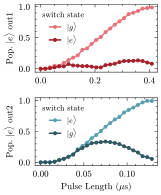

In [14]:

fig, ax = plt.subplots(2, 1, figsize=(2.5, 3))
# fig, ax = plt.subplots(2, 1, figsize=(2.0, 3))


y3_right = amp_13_right[0]
y3_wrong = amp_13_wrong[0]

y13_1_scaled = (y3_right - y3_right[0])/(np.max(y3_right) - np.min(y3_right))
# y13_2_scaled = (y2 - np.min(y3_right))/(np.max(y3_right) - np.min(y3_right)) 
y13_2_scaled = (y3_wrong - y3_wrong[0])/(np.max(y3_right) - np.min(y3_right)) 

# y13_1_scaled = y 
# y13_2_scaled = y2


y2_right = amp_12_right[0]
y2_wrong = amp_12_wrong[0]

y12_1_scaled = (y2_right - y2_right[0])/(np.max(y2_right) - np.min(y2_right))
# y12_2_scaled = (y2 - np.min(y2_right))/(np.max(y2_right) - np.min(y2_right))
y12_2_scaled = (y2_wrong - y2_wrong[0])/(np.max(y2_right) - np.min(y2_right))

# y12_1_scaled = y 
# y12_2_scaled = y2


# fit both with a sine function

# def fit_sin(x, A, B, C, D):
#     return A*np.sin(B*x + C) + D

# popt1, pcov1 = opt.curve_fit(fit_sin, t13_right, y13_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt2, pcov2 = opt.curve_fit(fit_sin, t13_wrong, y13_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)
# popt3, pcov3 = opt.curve_fit(fit_sin, t12_right, y12_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt4, pcov4 = opt.curve_fit(fit_sin, t12_wrong, y12_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)

# y13_1_fit = fit_sin(t13_right, *popt1)
# y13_2_fit = fit_sin(t13_wrong, *popt2)
# y12_1_fit = fit_sin(t12_right, *popt3)
# y12_2_fit = fit_sin(t12_wrong, *popt4)

# idx_stop_12 = -1
# idx_stop_13 = -1
idx_stop_12 = np.argmax(y12_1_scaled)# + 2
idx_stop_13 = np.argmax(y13_1_scaled)# + 2

ax[1].plot(t13_right[:idx_stop_13], y13_1_scaled[:idx_stop_13], 'o-', label=r'$|e\rangle$', color=color_dict['q1q3_right'])
ax[1].plot(t13_wrong[:idx_stop_13], y13_2_scaled[:idx_stop_13], 'o-', label=r'$|g\rangle$', color=color_dict['q1q3_wrong'])
# ax[1].plot(t13_right[:idx_stop_13], y13_1_fit[:idx_stop_13], color=color_dict['q1q3_right'])
# ax[1].plot(t13_wrong[:idx_stop_13], y13_2_fit[:idx_stop_13], color=color_dict['q1q3_wrong'])
# set subtitle
# ax[1].set_title('input - output 2')

ax[0].plot(t12_right[:idx_stop_12], y12_1_scaled[:idx_stop_12], 'o-', label=r'$|g\rangle$', color=color_dict['q1q2_right'])
ax[0].plot(t12_wrong[:idx_stop_12], y12_2_scaled[:idx_stop_12], 'o-', label=r'$|e\rangle$', color=color_dict['q1q2_wrong'])
# ax[0].plot(t12_right[:idx_stop_12], y12_1_fit[:idx_stop_12], color=color_dict['q1q2_right'])
# ax[0].plot(t12_wrong[:idx_stop_12], y12_2_fit[:idx_stop_12], color=color_dict['q1q2_wrong'])
# set subtitle
# ax[0].set_title('input - output 1')

ax[0].set_ylabel(r'Pop. $|e\rangle$ out1')
ax[1].set_ylabel(r'Pop. $|e\rangle$ out2')

ax[1].set_xlabel('Pulse Length ($\mu$s)')

ax[0].legend(title='switch state', frameon=False)
ax[1].legend(title='switch state', frameon=False)

fig.tight_layout()

filenames = [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]

filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

print(filepaths_str)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.pdf')
print("Saving", savename)
plt.savefig(savename)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.svg')
print("Saving", savename)
plt.savefig(savename)

plt.show()

25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900077_25011900078_25011900070_25011900071__length_rabi_EgGf.svg


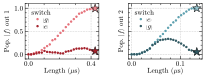

In [15]:
labelsize = 7

fig, ax = plt.subplots(1, 2, figsize=(3.0, 1.0), sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
# fig, ax = plt.subplots(2, 1, figsize=(2.0, 3))

y3_right = amp_13_right[0]
y3_wrong = amp_13_wrong[0]

y13_1_scaled = (y3_right - y3_right[0])/(np.max(y3_right) - np.min(y3_right))
# y13_2_scaled = (y2 - np.min(y3_right))/(np.max(y3_right) - np.min(y3_right)) 
y13_2_scaled = (y3_wrong - y3_wrong[0])/(np.max(y3_right) - np.min(y3_right)) 

# y13_1_scaled = y 
# y13_2_scaled = y2


y2_right = amp_12_right[0]
y2_wrong = amp_12_wrong[0]

y12_1_scaled = (y2_right - y2_right[0])/(np.max(y2_right) - np.min(y2_right))
# y12_2_scaled = (y2 - np.min(y2_right))/(np.max(y2_right) - np.min(y2_right))
y12_2_scaled = (y2_wrong - y2_wrong[0])/(np.max(y2_right) - np.min(y2_right))

# y12_1_scaled = y 
# y12_2_scaled = y2


# fit both with a sine function

# def fit_sin(x, A, B, C, D):
#     return A*np.sin(B*x + C) + D

# popt1, pcov1 = opt.curve_fit(fit_sin, t13_right, y13_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt2, pcov2 = opt.curve_fit(fit_sin, t13_wrong, y13_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)
# popt3, pcov3 = opt.curve_fit(fit_sin, t12_right, y12_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt4, pcov4 = opt.curve_fit(fit_sin, t12_wrong, y12_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)

# y13_1_fit = fit_sin(t13_right, *popt1)
# y13_2_fit = fit_sin(t13_wrong, *popt2)
# y12_1_fit = fit_sin(t12_right, *popt3)
# y12_2_fit = fit_sin(t12_wrong, *popt4)

# idx_stop_12 = -1
# idx_stop_13 = -1
idx_stop_12 = np.argmax(y12_1_scaled)# + 2
idx_stop_13 = np.argmax(y13_1_scaled)# + 2

plt.sca(ax[1])
plt.grid(color='k', alpha=0.2)
ax[1].plot(t13_right[:idx_stop_13], y13_1_scaled[:idx_stop_13], '.', label=r'$\left|e\right>$', color=color_dict['q1q3_right'])
ax[1].scatter(t13_right[idx_stop_13], y13_1_scaled[idx_stop_13], marker='*', c=star_color_dict["q1q3_right"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[1].plot(t13_wrong[:idx_stop_13], y13_2_scaled[:idx_stop_13], '.', label=r'$\left|g\right>$', color=color_dict['q1q3_wrong'])
ax[1].scatter(t13_wrong[idx_stop_13], y13_2_scaled[idx_stop_13], marker='*', c=star_color_dict["q1q3_wrong"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
# ax[1].plot(t13_right[:idx_stop_13], y13_1_fit[:idx_stop_13], color=color_dict['q1q3_right'])
# ax[1].plot(t13_wrong[:idx_stop_13], y13_2_fit[:idx_stop_13], color=color_dict['q1q3_wrong'])
# set subtitle
# ax[1].set_title('input - output 2')

plt.sca(ax[0])
plt.grid(color='k', alpha=0.2)
ax[0].plot(t12_right[:idx_stop_12], y12_1_scaled[:idx_stop_12], '.', label=r'$\left|g\right>$', color=color_dict['q1q2_right'])
ax[0].scatter(t12_right[idx_stop_12], y12_1_scaled[idx_stop_12], marker='*', c=star_color_dict["q1q2_right"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[0].plot(t12_wrong[:idx_stop_12], y12_2_scaled[:idx_stop_12], '.', label=r'$\left|e\right>$', color=color_dict['q1q2_wrong'])
ax[0].scatter(t12_wrong[idx_stop_12], y12_2_scaled[idx_stop_12], marker='*', c=star_color_dict["q1q2_wrong"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
# ax[0].plot(t12_right[:idx_stop_12], y12_1_fit[:idx_stop_12], color=color_dict['q1q2_right'])
# ax[0].plot(t12_wrong[:idx_stop_12], y12_2_fit[:idx_stop_12], color=color_dict['q1q2_wrong'])
# set subtitle
# ax[0].set_title('input - output 1')

ax[0].set_ylabel(r'Pop. $\left|f\right>$ out 1', fontsize=labelsize)
# ax[1].set_ylabel(r'Pop. $|e\rangle$ out2')

ax[0].set_xlabel('Length ($\mu$s)', fontsize=labelsize, labelpad=0.3)
ax[0].set_xticks([0, 0.4])
ax[0].set_xlim(None, 0.45)
ax[0].set_ylim(-0.1, 1.1)
ax[0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax[0].legend(title='switch', frameon=False, handletextpad=0.1, labelspacing=0.1, title_fontsize=labelsize, fontsize=labelsize) #, frameon=True, framealpha=0.7

ax[1].set_ylabel(r'Pop. $\left|f\right>$ out 2', fontsize=labelsize)
ax[1].set_xlabel('Length ($\mu$s)', fontsize=labelsize, labelpad=0.3)
ax[1].set_xticks([0, 0.10])
ax[1].set_xlim(None, 0.145)
ax[1].set_ylim(-0.1, 1.1)
ax[1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

ax[1].legend(title='switch', frameon=False, handletextpad=0.1, labelspacing=0.1, title_fontsize=labelsize, fontsize=labelsize) #, frameon=True, framealpha=0.7

# fig.tight_layout()

filenames = [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]

filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

print(filepaths_str)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.pdf')
print("Saving", savename)
plt.savefig(savename)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.svg')
print("Saving", savename)
plt.savefig(savename)

plt.show()

# Chevron right / wrong state

In [16]:
chevron_filename_q1q3_right = '00002_rabi_EgGf_freqlen_chevron_qubit31.h5'
chevron_filename_q1q3_wrong = '00003_rabi_EgGf_freqlen_chevron_qubit31.h5'
chevron_filename_q1q2_right = '00002_rabi_EgGf_freqlen_chevron_qubit21.h5'
chevron_filename_q1q2_wrong = '00003_rabi_EgGf_freqlen_chevron_qubit21.h5'
# chevron_filename_q1q3_right = '00000_rabi_EgGf_freqlen_chevron_qubit31.h5'
# chevron_filename_q1q3_wrong = '00001_rabi_EgGf_freqlen_chevron_qubit31.h5'
# chevron_filename_q1q2_right = '00000_rabi_EgGf_freqlen_chevron_qubit21.h5'
# chevron_filename_q1q2_wrong = '00001_rabi_EgGf_freqlen_chevron_qubit21.h5'


folder = 'data_250119'

files = []

for f in [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong, chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]:
    file = h5py.File(data_dir + '/' + folder + '/' + f, 'r')
    files.append(file)

In [17]:
qb_plot = 0
data_13 = 'amps'
data_12 = 'amps'
# data_12 = 'avgi'

amp_13_right_2d = np.asarray(files[0][data_13])
amp_13_wrong_2d = np.asarray(files[1][data_13])
amp_12_right_2d = 1 - np.asarray(files[2][data_12])
amp_12_wrong_2d = 1 - np.asarray(files[3][data_12])

freqs_13_right = np.asarray(files[0]['freqpts'])
freqs_13_wrong = np.asarray(files[1]['freqpts'])
freqs_12_right = np.asarray(files[2]['freqpts'])
freqs_12_wrong = np.asarray(files[3]['freqpts'])

t13_right_2d = np.asarray(files[0]['lenpts'])*2*1e-3
t13_wrong_2d = np.asarray(files[1]['lenpts'])*2*1e-3
t12_right_2d = np.asarray(files[2]['lenpts'])*2*1e-3
t12_wrong_2d = np.asarray(files[3]['lenpts'])*2*1e-3




In [18]:
import matplotlib as mpl

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron_13.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron_12.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron_13.svg
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron_12.svg


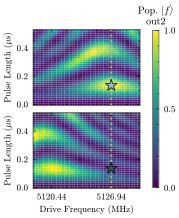

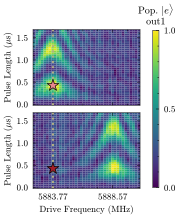

In [19]:
# fig, axes = plt.subplots(gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(2.5, 3))

fig, ax = plt.subplots(2, 1, figsize=(2.5*0.85, 3*0.95), sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig.subplots_adjust(hspace=0.1)

y_12_right_2d = -amp_12_right_2d[qb_plot].T ## minus sign to match the amplitude of the other qubit
y_12_wrong_2d = -amp_12_wrong_2d[qb_plot].T

y_12_right_scaled_2d = (y_12_right_2d - y_12_right_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))
y_12_wrong_scaled_2d = (y_12_wrong_2d - y_12_wrong_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))

y_13_right_2d = amp_13_right_2d[qb_plot].T
y_13_wrong_2d = amp_13_wrong_2d[qb_plot].T 
y_13_right_scaled_2d = (y_13_right_2d - y_13_right_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))
y_13_wrong_scaled_2d = (y_13_wrong_2d - y_13_wrong_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))


x_12_right_2d = freqs_12_right # - f_right_12
x_12_wrong_2d = freqs_12_wrong # - f_right_12

x_13_right_2d = freqs_13_right # - f_right_13
x_13_wrong_2d = freqs_13_wrong # - f_right_13


ax[0].pcolor(x_13_right_2d, t13_right_2d*1e3,y_13_right_scaled_2d, cmap='viridis')
ax[0].axvline(f_right_13, color=highlight_color, linestyle=':', linewidth=2)
ax[0].scatter(f_right_13, len_13, marker='*', c=star_color_dict["q1q3_right"], edgecolors='k', s=150, linewidths=0.7, zorder=10)
ax[1].pcolor(x_13_wrong_2d, t13_wrong_2d*1e3, y_13_wrong_scaled_2d, cmap='viridis')
ax[1].axvline(f_right_13, color=highlight_color, linestyle=':', linewidth=2)
ax[1].scatter(f_right_13, len_13, marker='*', c=star_color_dict["q1q3_wrong"], edgecolors='k', s=150, linewidths=0.7, zorder=10)

ax[1].set_ylabel('Pulse Length ($\mu$s)')
ax[0].set_ylabel('Pulse Length ($\mu$s)')
ax[1].set_xticks([f_right_13, f_wrong_13])


# add a colorbar

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax, location='right', aspect=25, ticks=[0, 0.5, 1], fraction=0.05, pad=0.1)
cbar.ax.set_title(r'Pop. $|f\rangle$' + '\nout2', fontsize=10)

# put the colorbar closer to the figurer

cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

# ax[1].set_xlabel('$f - f_\mathrm{eg-gf}^\mathrm{in-out2}$ (MHz)')
ax[1].set_xlabel('Drive Frequency (MHz)')



# fig.tight_layout()


fig2, ax2 = plt.subplots(2, 1, figsize=(2.5*0.85, 3*0.95), sharex=True)
# fig2, ax2 = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig2.subplots_adjust(hspace=0.1)


ax2[0].pcolor(x_12_right_2d, t12_right_2d*1e3, y_12_right_scaled_2d, cmap='viridis')
ax2[0].axvline(f_right_12, color=highlight_color, linestyle=':', linewidth=2)
ax2[0].scatter(f_right_12, len_12, marker='*', c=star_color_dict["q1q2_right"], edgecolors='k', s=150, linewidths=0.7, zorder=10)

ax2[1].pcolor(x_12_wrong_2d, t12_wrong_2d*1e3, y_12_wrong_scaled_2d, cmap='viridis')
ax2[1].axvline(f_right_12, color=highlight_color, linestyle=':', linewidth=2)
ax2[1].scatter(f_right_12, len_12, marker='*', c=star_color_dict["q1q2_wrong"], edgecolors='k', s=150, linewidths=0.7, zorder=10)

# ax2[1].set_xlabel('$f - f_\mathrm{eg-gf}^\mathrm{in-out1}$ (MHz)')
ax2[1].set_xlabel('Drive Frequency (MHz)')
ax2[1].set_ylabel('Pulse Length ($\mu$s)')
ax2[0].set_ylabel('Pulse Length ($\mu$s)')
ax2[1].set_xticks([f_right_12, f_wrong_12])



cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax2, location='right', aspect=25, ticks=[0, 0.5, 1], fraction=0.05, pad=0.1)
cbar.ax.set_title(r'Pop. $|e\rangle$' + '\nout1', fontsize=10)


for filetype in ['pdf', 'svg']:
    filenames = [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong]
    filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    savename = os.path.join(save_plot_path, 'calib', f'chevron_{filepaths_str}_13.{filetype}')
    print("Saving", savename)
    fig.savefig(savename)


    filenames = [chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]
    filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    savename = os.path.join(save_plot_path, 'calib', f'chevron_{filepaths_str}_12.{filetype}')
    print("Saving", savename)
    fig2.savefig(savename)

## All the chevrons together

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_combined_25011900002_25011900003__rabi_EgGf_freqlen_chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_combined_25011900002_25011900003__rabi_EgGf_freqlen_chevron_25011900002_25011900003__rabi_EgGf_freqlen_chevron.svg


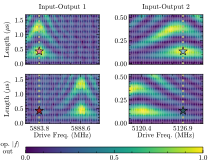

In [20]:
labelsize = 7
# fig, axes = plt.subplots(gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(2.5, 3))

fig, ax = plt.subplots(2, 2, figsize=(3.0, 2.8))
# fig, ax = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig.subplots_adjust(hspace=0.2, wspace=0.4)

y_12_right_2d = -amp_12_right_2d[qb_plot].T ## minus sign to match the amplitude of the other qubit
y_12_wrong_2d = -amp_12_wrong_2d[qb_plot].T

y_12_right_scaled_2d = (y_12_right_2d - y_12_right_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))
y_12_wrong_scaled_2d = (y_12_wrong_2d - y_12_wrong_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))

y_13_right_2d = amp_13_right_2d[qb_plot].T
y_13_wrong_2d = amp_13_wrong_2d[qb_plot].T 
y_13_right_scaled_2d = (y_13_right_2d - y_13_right_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))
y_13_wrong_scaled_2d = (y_13_wrong_2d - y_13_wrong_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))


x_12_right_2d = freqs_12_right # - f_right_12
x_12_wrong_2d = freqs_12_wrong # - f_right_12

x_13_right_2d = freqs_13_right # - f_right_13
x_13_wrong_2d = freqs_13_wrong # - f_right_13



# COLUMN 1 FOR Q1-Q2
ax[0, 0].set_title("Input-Output 1", fontsize=labelsize)
ax[0, 0].pcolor(x_12_right_2d, t12_right_2d*1e3, y_12_right_scaled_2d, cmap='viridis')
ax[0, 0].axvline(f_right_12, color=highlight_color, linestyle=':', linewidth=2)
ax[0, 0].scatter(f_right_12, len_12, marker='*', c=star_color_dict["q1q2_right"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[1, 0].pcolor(x_12_wrong_2d, t12_wrong_2d*1e3, y_12_wrong_scaled_2d, cmap='viridis')
ax[1, 0].axvline(f_right_12, color=highlight_color, linestyle=':', linewidth=2)
ax[1, 0].scatter(f_right_12, len_12, marker='*', c=star_color_dict["q1q2_wrong"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[1, 0].set_xlabel('Drive Freq. (MHz)', fontsize=labelsize, labelpad=0.1)
ax[1, 0].set_ylabel('Length ($\mu$s)', fontsize=labelsize)
ax[0, 0].set_ylabel('Length ($\mu$s)', fontsize=labelsize)
ax[0, 0].set_yticks([0, 0.5, 1.0, 1.5])
ax[1, 0].set_yticks([0, 0.5, 1.0, 1.5])
plt.setp(ax[0, 0].get_xticklabels(), visible=False)
ax[1, 0].set_xticks([np.round(f_right_12, 1), np.round(f_wrong_12, 1)])
ax[0, 0].sharex(ax[1, 0])



for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)


# COLUMN 2 FOR Q1-Q3
ax[0, 1].set_title("Input-Output 2", fontsize=labelsize)
ax[0, 1].pcolor(x_13_right_2d, t13_right_2d*1e3,y_13_right_scaled_2d, cmap='viridis')
ax[0, 1].axvline(f_right_13, color=highlight_color, linestyle=':', linewidth=2)
ax[0, 1].scatter(f_right_13, len_13, marker='*', c=star_color_dict["q1q3_right"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[1, 1].pcolor(x_13_wrong_2d, t13_wrong_2d*1e3, y_13_wrong_scaled_2d, cmap='viridis')
ax[1, 1].axvline(f_right_13, color=highlight_color, linestyle=':', linewidth=2)
ax[1, 1].scatter(f_right_13, len_13, marker='*', c=star_color_dict["q1q3_wrong"], edgecolors='k', s=80, linewidths=0.5, zorder=10)
ax[1, 1].set_xlabel('Drive Freq. (MHz)', fontsize=labelsize, labelpad=0.1)
# ax[1, 1].set_ylabel('Pulse Length ($\mu$s)')
# ax[0, 1].set_ylabel('Pulse Length ($\mu$s)')
ax[0, 1].set_yticks([0, 0.25, 0.5])
ax[1, 1].set_yticks([0, 0.25, 0.5])
plt.setp(ax[0, 1].get_xticklabels(), visible=False)
ax[1, 1].set_xticks([np.round(f_right_13, 1), np.round(f_wrong_13, 1)])
ax[0, 1].sharex(ax[1, 1])


# add a colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax, location='bottom', aspect=30, ticks=[0, 0.5, 1], pad=0.15)
cbar.ax.set_xlabel(r'Pop. $\left|f\right>$' + '\nout', fontsize=labelsize) #, x=0, ha='left') # , loc='left', x=0.5) #, size=10)
cbar.ax.xaxis.set_label_coords(-0.1, 2.0)
cbar.ax.tick_params(labelsize=labelsize, pad=2)

# put the colorbar closer to the figure
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')


for filetype in ['pdf', 'svg']:
    filenames = [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong]
    filepaths_str_13 = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    filenames = [chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]
    filepaths_str_12 = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    filepaths_str = filepaths_str_13 + '_' + filepaths_str_12


    savename = os.path.join(save_plot_path, 'calib', f'chevron_combined_{filepaths_str}.{filetype}')
    print("Saving", savename)
    fig.savefig(savename)

# Swap pi/-pi

In [21]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)

Data dir S:\QRAM\qram_4QR2\data\data_250119


In [51]:
pmp_path = "00072_PiMinusPiEgGfExptQ31"
pmp_save_path = 'S:\\Connie\\experiments\\qram_tprocv1_expts\\data_plot\\PMP_SWAP'

Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00072_PiMinusPiEgGfExptQ31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'angles', 'avgi', 'avgq', 'best_freq', 'counts_calib', 'cycle_sweep', 'fit_q1_amps', 'fit_q1_err_amps', 'fit_q3_amps', 'fit_q3_err_amps', 'freq_sweep', 'ge_avgs', 'phases', 'products', 'thresholds', 'xpts'])
Fit best freq (Q3) 5139.587865321054 which is 7.201071570465501 away from old freq 5132.386793750588
Fit best freq (Q1) 5139.593983690286 which is 7.207189939697855 away from old freq 5132.386793750588
best 0 0.06233620080873134
Best freq fitted 5139.587865321054


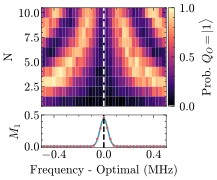

25011900072_PiMinusPiEgGfExptQ31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_25011900072_PiMinusPiEgGfExptQ31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_25011900072_PiMinusPiEgGfExptQ31.svg


In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pmp = meas.PiMinusPiEgGfExperiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pmp_path+'.h5'))
print(data.keys())
pmp.cfg = AttrDict(attrs["config"])

data = pmp.analyze(data=data, fit=True)
data_pmp_swap = data

qA, qB = pmp.cfg.expt.qubits

inner_sweep = data["freq_sweep"]
outer_sweep = data["cycle_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

prod_data = data["products"][0] * data["products"][1]
x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)
fit_freq = popt[1]

x_sweep -= fit_freq
popt[1] -= fit_freq
x_sweep_fit -= fit_freq
fit_freq = 0
y_fit = meas.fitting.gaussian(x_sweep_fit, *popt)
data_pmp_swap['y_fit'] = y_fit
data_pmp_swap['x_sweep_fit'] = x_sweep_fit

labelsize = 12
cmap = 'magma'

fig, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(3.0, 2.5))

axes[1,1].remove()

a0 = axes[0, 0]
plt.sca(a0)
a0.set_ylabel(f"N", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelbottom=False, labelsize=labelsize, pad=2)
data_name = "amps"
plot_data = data[data_name][0] # 0 for qDrive, 1 for q1
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g
plot_data = (plot_data - scaled_g) / scale_ge
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap=cmap, shading="auto")
plt.axvline(fit_freq, color="w", linestyle="--")

acbar = axes[0, 1]
# plt.sca(acbar)
cbar = plt.colorbar(cax=acbar, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Prob. $Q_O=|1\\rangle$', size=labelsize)

a1 = axes[1, 0]
a1.sharex(a0)
plt.sca(a1)
a1.set_ylabel("$M_1$", fontsize=labelsize)
a1.set_xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a1.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.plot(x_sweep_fit, y_fit)
plt.plot(x_sweep, prod_data, ".")
plt.axvline(fit_freq, color="k", linestyle="--")
# plt.ylim([-0.05, 0.6])
a1.set_yticks([0.0, 0.5])
plt.xlim([-0.5, 0.5])
a1.set_xticks([-0.4, 0, 0.4])

plt.tight_layout(pad=0.2)
plt.show()


filepaths_str = folder[5:] + pmp_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    

In [61]:
# save the data
savename = os.path.join(pmp_save_path, f'piminuspi_{filepaths_str}.npz')
print("Saving", savename)
np.savez(savename, **data_pmp_swap)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\PMP_SWAP\piminuspi_25011900072_PiMinusPiEgGfExptQ31.npz


In [62]:
pmp_sweep_path = "00006_eggf_piminuspi_gain_sweep_Q31"
data_pmp_sweep = {}

Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00006_eggf_piminuspi_gain_sweep_Q31.h5
Extracted data and attrs ['config']


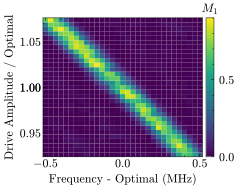

25011900006_eggf_piminuspi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_sweep_25011900006_eggf_piminuspi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_sweep_25011900006_eggf_piminuspi_gain_sweep_Q31.svg


In [73]:
pmp_sweep = meas.Experiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pmp_sweep_path+'.h5'))
pmp_sweep.data = data
data_pmp_sweep = data
cfg = AttrDict(attrs["config"])

qA, qB = pmp_sweep_path[-2:]
qA = int(qA)
qB = int(qB)
opt_gain = cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qA]
opt_freq = cfg.device.qubit.f_EgGf_Q_half[qA]
data_pmp_sweep['opt_gain'] = opt_gain
data_pmp_sweep['opt_freq'] = opt_freq

cycle_sweep = data["cycle_sweep"]
label = "($X_{\pi}, X_{-\pi})^N$"
# label = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"

inner_sweep = data["freq_sweep"]
outer_sweep = data["gain_sweep"]
y_sweep = outer_sweep
x_sweep = inner_sweep

x_sweep -= opt_freq
y_sweep /= opt_gain
data_pmp_sweep['x_sweep'] = x_sweep
data_pmp_sweep['y_sweep'] = y_sweep

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
data_name = "products"
plot_data = data[data_name][0] * data[data_name][1]

a0 = plt.subplot(111)
a0.set_ylabel(f"Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.5, 0, 0.5])
ymin = np.min(y_sweep)
ymax = np.max(y_sweep)
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks(ytick_labels)

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_1$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pmp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

In [75]:
#save the data
savename = os.path.join(pmp_save_path, f'piminuspi_sweep_{filepaths_str}.npz')
print("Saving", savename)
np.savez(savename, **data_pmp_sweep)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\PMP_SWAP\piminuspi_sweep_25011900006_eggf_piminuspi_gain_sweep_Q31.npz


# Swap pi train

In [77]:
pp_path = "00071_eggf_train_Q31"


Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00071_eggf_train_Q31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'angles', 'avgi', 'avgq', 'best_gain', 'counts_calib', 'cycle_sweep', 'fit_q1_avgi', 'fit_q1_err_avgi', 'fit_q3_avgi', 'fit_q3_err_avgi', 'gain_sweep', 'ge_avgs', 'products', 'thresholds'])
6679.170094901532


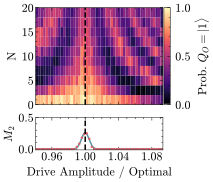

25011900071_eggf_train_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_25011900071_eggf_train_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_25011900071_eggf_train_Q31.svg


In [84]:
pp = meas.PiTrainEgGfGainSweepExperiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pp_path+'.h5'))
print(data.keys())
data_pp = data
pp.cfg = AttrDict(attrs["config"])

# pp.analyze(data=data, fit=True)

qA, qB = pp.cfg.expt.qubits

inner_sweep = data["gain_sweep"]
outer_sweep = data["cycle_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

prod_data = data["products"][0] * data["products"][1]
x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)
fit_gain = popt[1]
print(fit_gain)

x_sweep /= fit_gain
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)


data_pp['x_sweep'] = x_sweep
data_pp['y_sweep'] = y_sweep

x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
data_pp['x_sweep_fit'] = x_sweep_fit
data_pp['y_fit'] = meas.fitting.gaussian(x_sweep_fit, *popt)
fit_gain = 1

labelsize = 12
cmap = 'magma'

fig, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(3.0, 2.5))

axes[1,1].remove()

a0 = axes[0, 0]
plt.sca(a0)
a0.set_ylabel(f"N", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelbottom=False, labelsize=labelsize, pad=2)
data_name = "amps"
plot_data = data[data_name][0] # 0 for qDrive, 1 for q1
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g
plot_data = (plot_data - scaled_g) / scale_ge
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap=cmap, shading="auto")
plt.axvline(fit_gain, color="k", linestyle="--")

acbar = axes[0, 1]
# plt.sca(acbar)
cbar = plt.colorbar(cax=acbar, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Prob. $Q_O=|1\\rangle$', size=labelsize)

a1 = axes[1, 0]
a1.sharex(a0)
plt.sca(a1)
a1.set_ylabel("$M_2$", fontsize=labelsize)
a1.set_xlabel("Drive Amplitude / Optimal", fontsize=labelsize)
a1.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.plot(x_sweep_fit, meas.fitting.gaussian(x_sweep_fit, *popt))
plt.plot(x_sweep, prod_data, ".")
plt.axvline(fit_gain, color="k", linestyle="--")
# plt.ylim([-0.05, 0.4])
a1.set_yticks([0.0, 0.5])
a1.set_xticks([0.96, 1.0, 1.04, 1.08])

plt.tight_layout(pad=0.1)
plt.show()


filepaths_str = folder[5:] + pp_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    

In [85]:
savename = os.path.join(pmp_save_path, f'pipi_sweep_{filepaths_str}.npz')
print("Saving", savename)
np.savez(savename, **data_pp)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\PMP_SWAP\pipi_sweep_25011900071_eggf_train_Q31.npz


In [ ]:
pp_sweep_path = "00008_eggf_pipi_gain_sweep_Q31"
data_pp_sweep = {}

Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00008_eggf_pipi_gain_sweep_Q31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'avgi', 'avgq', 'cycle_sweep', 'freq_sweep', 'gain_sweep', 'products'])


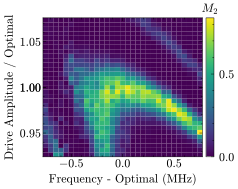

25011900008_eggf_pipi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_sweep_25011900008_eggf_pipi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_sweep_25011900008_eggf_pipi_gain_sweep_Q31.svg


In [86]:
pp_sweep = meas.Experiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pp_sweep_path+'.h5'))
pp_sweep.data = data
data_pp_sweep = data
print(data.keys())
cfg = AttrDict(attrs["config"])

qA, qB = pp_sweep_path[-2:]
qA = int(qA)
qB = int(qB)
opt_gain = cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qA]
opt_freq = cfg.device.qubit.f_EgGf_Q_half[qA]

cycle_sweep = data["cycle_sweep"]
label = "($X_{\pi}, X_{-\pi})^N$"
# label = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"

inner_sweep = data["freq_sweep"]
outer_sweep = data["gain_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

x_sweep -= opt_freq
y_sweep /= opt_gain

data_pp_sweep['x_sweep'] = x_sweep
data_pp_sweep['y_sweep'] = y_sweep

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
data_name = "products"
plot_data = data[data_name][0] * data[data_name][1]
data_pp_sweep['plot_data'] = plot_data
a0 = plt.subplot(111)
a0.set_ylabel(f"Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.5, 0, 0.5])
ymin = np.min(y_sweep)
ymax = np.max(y_sweep)
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks(ytick_labels)

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_2$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

In [88]:
savename = os.path.join(pmp_save_path, f'pipi_sweep_{filepaths_str}.npz')
print("Saving", savename)
np.savez(savename, **data_pp_sweep)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\PMP_SWAP\pipi_sweep_25011900008_eggf_pipi_gain_sweep_Q31.npz


# Product of pi/-pi and pi/pi

In [326]:
def calculate_gain_freq_tuples(qubits, pipi_data, piminuspi_data, opt_len, interpolate=True, plot=True, test_pi_half=True):
    if interpolate:
        pipi_freq_sweep, pipi_gain_sweep = pipi_data["freq_sweep"], pipi_data["gain_sweep"]
        piminuspi_freq_sweep, piminuspi_gain_sweep = piminuspi_data["freq_sweep"], piminuspi_data["gain_sweep"]
        reduced_freq_sweep = np.linspace(np.max([pipi_freq_sweep[0], piminuspi_freq_sweep[0]]), np.min([pipi_freq_sweep[-1], piminuspi_freq_sweep[-1]]), 20)
        reduced_gain_sweep = np.linspace(np.max([pipi_gain_sweep[0], piminuspi_gain_sweep[0]]), np.min([pipi_gain_sweep[-1], piminuspi_gain_sweep[-1]]), 25)
        reduced_y = reduced_gain_sweep
        reduced_x = reduced_freq_sweep
        
        print("reduced gain range", reduced_gain_sweep[0], "to", reduced_gain_sweep[-1])
        print("reduced freq range", reduced_freq_sweep[0], "to", reduced_freq_sweep[-1])

        fine_pipi_data = np.zeros((2, len(reduced_y), len(reduced_x)))
        fine_piminuspi_data = np.zeros((2, len(reduced_y), len(reduced_x)))
        for iq in range (2):
            y, x = pipi_gain_sweep, pipi_freq_sweep
            pipi_interp = sp.interpolate.RegularGridInterpolator((y, x), pipi_data["products"][iq], bounds_error=False, fill_value=0)

            y, x = piminuspi_gain_sweep, piminuspi_freq_sweep
            piminuspi_interp = sp.interpolate.RegularGridInterpolator((y, x), piminuspi_data["products"][iq], bounds_error=False, fill_value=0)

            yg, xg = np.meshgrid(reduced_y, reduced_x, indexing='ij')
            fine_pipi_data[iq] = pipi_interp((yg, xg))
            fine_piminuspi_data[iq] = piminuspi_interp((yg, xg))

    else:
        assert np.all([pipi_data["freq_sweep"][i] == piminuspi_data["freq_sweep"][i] for i in range(len(pipi_data["freq_sweep"]))])
        assert np.all([pipi_data["gain_sweep"][i] == piminuspi_data["gain_sweep"][i] for i in range(len(pipi_data["gain_sweep"]))])
        assert len(pipi_data["freq_sweep"]) == len(piminuspi_data["freq_sweep"])
        assert len(pipi_data["gain_sweep"]) == len(piminuspi_data["gain_sweep"])
        fine_pipi_data = pipi_data["products"]
        fine_piminuspi_data = piminuspi_data["products"]
        reduced_x = pipi_data["freq_sweep"]
        reduced_y = pipi_data["gain_sweep"]

    x_sweep = reduced_x
    y_sweep = reduced_y

    prod_of_prods_data_q = np.array([fine_piminuspi_data[i] * fine_pipi_data[i] for i in range(2)])

    qA, qB = qubits

    # Interpolated pi pi data
    label_pipi = "($X_{\pi}, X_{\pi})^N$"
    if test_pi_half:
        label_pipi = "($X_{\pi/2}, X_{\pi/2})^{2N}$"
    title = (
        f"Interpolated Q{qA}/Q{qB} Product of Ns for {label_pipi}\n Len {opt_len:.3f}, Ns={pipi_data['cycle_sweep'].tolist()}"
    )

    if plot:
        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_pipi_data[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_pipi_data[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

        # Interpolated pi -pi data
        label_piminuspi = "($X_{\pi}, X_{-\pi})^N$"
        if test_pi_half:
            # label_piminuspi = "($X_{\pi/2}, X_{-\pi/2})^{N}$"
            label_piminuspi = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"
        title = (
            f"Interpolated Q{qA}/Q{qB} Product of Ns for {label_piminuspi}\n Len {opt_len:.3f}, Ns={piminuspi_data['cycle_sweep'].tolist()}"
        )

        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_piminuspi_data[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_piminuspi_data[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

        # Product of the two inteprolated data sets
        title = (
            f"Interpolated Q{qA}/Q{qB} Product {label_piminuspi} $\\times$ {label_pipi}\n Len {opt_len:.3f}"
        )

        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = prod_of_prods_data_q[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)
    
        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = prod_of_prods_data_q[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

    return np.prod(prod_of_prods_data_q, axis=0), x_sweep, y_sweep

In [327]:
from skimage.feature import blob_dog, blob_log, blob_doh
from matplotlib.patches import Ellipse

def find_blobs(data_2d, x_sweep, y_sweep):
    data_2d = (np.copy(data_2d) - np.min(data_2d))/(np.max(data_2d) - np.min(data_2d))
    blobs_log = blob_log(data_2d, max_sigma=5, min_sigma=3, num_sigma=10, threshold=0.1, exclude_border=True)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(data_2d, max_sigma=5, min_sigma=3, threshold=0.1, exclude_border=True)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(data_2d, max_sigma=5, min_sigma=3, threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)

    idxy = np.argmax(data_2d)
    i_ymax, i_xmax = np.unravel_index(idxy, data_2d.shape)
    x_max = x_sweep[i_xmax]
    y_max = y_sweep[i_ymax]

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        # ax[idx].imshow(data_2d)
        plt.sca(ax[idx])
        plt.pcolormesh(x_sweep, y_sweep, data_2d, cmap="viridis", shading="auto")
        for blob in blobs:
            r, c, sigma = blob
            opt_freq = x_sweep[int(c)]
            opt_gain = y_sweep[int(r)]
            sigma_x = sigma * (x_sweep[1] - x_sweep[0])
            sigma_y = sigma * (y_sweep[1] - y_sweep[0])
            c = Ellipse((opt_freq, opt_gain), width=sigma_x, height=sigma_y, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        plt.plot(x_max, y_max, "o", markersize=8, markeredgecolor="r", markerfacecolor="None")
        plt.colorbar()
        # ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

    # return blobs_list
    return blobs_log


reduced gain range 0.9263839811542992 to 1.073616018845701
reduced freq range -0.5 to 0.5


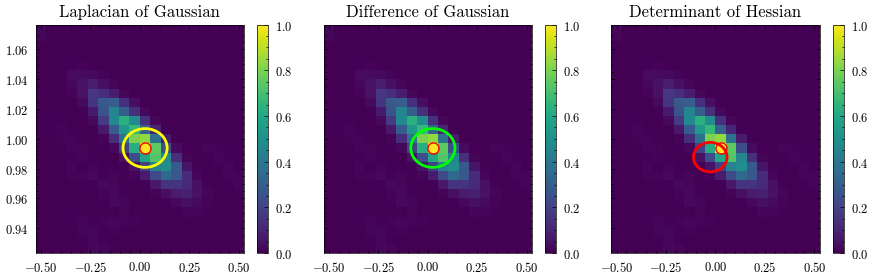

best freq from max 0.02631578947368418
best gain from max 0.9938653317628583
num blobs found 1
best freq from blob 0.02631578947368418
best gain from blob 0.9938653317628583


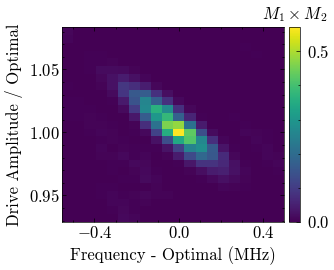

25011900008_eggf_pipi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\ppXpmp_sweep_25011900008_eggf_pipi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\ppXpmp_sweep_25011900008_eggf_pipi_gain_sweep_Q31.svg


In [355]:
pipi_data = pp_sweep.data
piminuspi_data = pmp_sweep.data

prod_of_prods_data, x_sweep, y_sweep = calculate_gain_freq_tuples([qA, qB], pipi_data, piminuspi_data, opt_len=0, interpolate=True, plot=False)
blobs = find_blobs(prod_of_prods_data, x_sweep=x_sweep, y_sweep=y_sweep)

idxy = np.argmax(prod_of_prods_data)
ymax, xmax = np.unravel_index(idxy, prod_of_prods_data.shape)
pi_freq_max = x_sweep[xmax]
pi_gain_max = y_sweep[ymax]
print("best freq from max", pi_freq_max)
print("best gain from max", pi_gain_max)

print("num blobs found", len(blobs))
if len(blobs) > 0:
    r, c, sigma = blobs[0]
    pi_freq_blob = x_sweep[int(c)]
    pi_gain_blob = y_sweep[int(r)]
    sigma_x = sigma * (x_sweep[1] - x_sweep[0])
    sigma_y = sigma * (y_sweep[1] - y_sweep[0])
    print("best freq from blob", pi_freq_blob)
    print("best gain from blob", pi_gain_blob)

if len(blobs) == 0:
    print("WARNING: no blobs found!")
elif np.abs(pi_freq_max - pi_freq_blob) > 2*sigma_x or np.abs(pi_gain_max - pi_gain_blob) > 2*sigma_y:
    print('WARNING: max product location is not close to found blob center!')


opt_freq = pi_freq_blob
opt_gain = pi_gain_blob
# opt_freq = pi_freq_max
# opt_gain = pi_gain_max

x_sweep -= opt_freq
y_sweep /= opt_gain

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
plot_data = prod_of_prods_data

a0 = plt.subplot(111)
a0.set_ylabel("Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.4, 0, 0.4])
# ymin = np.min(y_sweep)
# ymax = np.max(y_sweep)
# ytick_spacing = 0.05
# ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks([0.95, 1.0, 1.05])

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_1 \\times M_2$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'ppXpmp_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'ppXpmp_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

# CSWAP leakage

In [21]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)

swap_leak_save_path = 'S:\\Connie\\experiments\\qram_tprocv1_expts\\data_plot\\SWAP_leakage'

Data dir S:\QRAM\qram_4QR2\data\data_250119


In [ ]:
leakage_21_paths = [
    "00002_leakage_EgGf_qubit21",
    "00003_leakage_EgGf_qubit21",
    "00004_leakage_EgGf_qubit21",
    "00005_leakage_EgGf_qubit21",
    "00011_leakage_EgGf_qubit21",
    "00012_leakage_EgGf_qubit21",
    "00013_leakage_EgGf_qubit21",
]

leakage_31_paths = [
    "00006_leakage_EgGf_qubit31",
    "00007_leakage_EgGf_qubit31",
    "00008_leakage_EgGf_qubit31",
    "00009_leakage_EgGf_qubit31",
    "00019_leakage_EgGf_qubit31",
    "00010_leakage_EgGf_qubit31",
]



In [38]:
data_21 = []
leakage_lens_21 = []
freq_21 = []

for leakage_path in leakage_21_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_21.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[2])
    freq_21.append(rbprog.cfg.device.qubit.f_EgGf_Q_half[2])
    data_21.append(data)

Processing 00002_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00002_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00003_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00003_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00004_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00004_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00005_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00005_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00011_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00011_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00012_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00012_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00013_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00013_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [39]:
# save the data
savename = os.path.join(swap_leak_save_path, f'leakage_21_{folder[5:]}.npz')
print("Saving", savename)
np.savez(savename, data=data_21,
         leakage_lens=leakage_lens_21, 
         freq=freq_21)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\leakage_21_250119.npz


In [40]:
data_31 = []
leakage_lens_31 = []
freq_31 = []
for leakage_path in leakage_31_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_31.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[3])
    freq_31.append(rbprog.cfg.device.qubit.f_EgGf_Q_half[3])
    data_31.append(data)

Processing 00006_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00006_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00007_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00007_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00008_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00008_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00009_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00009_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00019_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00019_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00010_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00010_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [41]:
# save the data
savename = os.path.join(swap_leak_save_path, f'leakage_31_{folder[5:]}.npz')
print("Saving", savename)
np.savez(savename, data=data_31,
         leakage_lens=leakage_lens_31, 
            freq=freq_31)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\leakage_31_250119.npz


In [42]:
leakage_21_fast_paths = [
    # "00017_leakage_EgGf_qubit21", # 0.065
    "00020_leakage_EgGf_qubit21", # 0.075
    "00022_leakage_EgGf_qubit21", # 0.083
    "00019_leakage_EgGf_qubit21", # 0.090
    "00021_leakage_EgGf_qubit21", # 0.095
    "00018_leakage_EgGf_qubit21", # 0.105
]
leakage_31_fast_paths = [
    "00030_leakage_EgGf_qubit31", # 0.050
    "00031_leakage_EgGf_qubit31", # 0.060
    "00032_leakage_EgGf_qubit31", # 0.067
    "00033_leakage_EgGf_qubit31", # 0.070
    "00034_leakage_EgGf_qubit31", # 0.080
]

In [43]:
data_21_fast = []
leakage_lens_21_fast = []
freq_21_fast = []
for leakage_path in leakage_21_fast_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_21_fast.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[2])
    freq_21_fast.append(rbprog.cfg.device.qubit.f_EgGf_Q_half[2])
    data_21_fast.append(data)

Processing 00020_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00020_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00022_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00022_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00019_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00019_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00021_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00021_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00018_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00018_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
# save the data
savename = os.path.join(swap_leak_save_path, f'leakage_21_fast_{folder[5:]}.npz')
print("Saving", savename)
np.savez(savename, data=data_21_fast, leakage_lens=leakage_lens_21_fast, 
         freq=freq_21_fast)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\leakage_21_fast_250119.npz


In [45]:
data_31_fast = []
leakage_lens_31_fast = []
freq_31_fast = []
for leakage_path in leakage_31_fast_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_31_fast.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[3])
    freq_31_fast.append(rbprog.cfg.device.qubit.f_EgGf_Q_half[3])
    data_31_fast.append(data)

Processing 00030_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00030_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00031_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00031_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00032_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00032_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00033_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00033_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00034_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00034_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [46]:
# save the data
savename = os.path.join(swap_leak_save_path, f'leakage_31_fast_{folder[5:]}.npz')
print("Saving", savename)
np.savez(savename, data=data_31_fast, leakage_lens=leakage_lens_31_fast, 
         freq=freq_31_fast)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\leakage_31_fast_250119.npz


In [18]:
def get_bad(qDrive):
    if qDrive == 2: return "e"
    if qDrive == 3: return "g"
    return None

def get_good(qDrive):
    if qDrive == 3: return "e"
    if qDrive == 2: return "g"
    return None

In [157]:
pop_Bgf_21 = []
depths_21 = []
# print(data_21[0].keys())
for data in data_21:
    # pop_Bgf_21.append(data["popln_Bgf_avg"])
    pop_Bgf_21.append(data["popln_Bgf_avg"]+ data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_21.append(unique_depths)

pop_Bgf_31 = []
depths_31 = []
for data in data_31:
    # pop_Bgf_31.append(data["popln_Bgf_avg"])
    pop_Bgf_31.append(data["popln_Bgf_avg"] + data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_31.append(unique_depths)

In [158]:
pop_Bgf_21_fast = []
depths_21_fast = []
# print(data_21[0].keys())
for data in data_21_fast:
    # pop_Bgf_21.append(data["popln_Bgf_avg"])
    pop_Bgf_21_fast.append(data["popln_Bgf_avg"]+ data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_21_fast.append(unique_depths)

pop_Bgf_31_fast = []
depths_31_fast = []
for data in data_31_fast:
    # pop_Bgf_31_fast.append(data["popln_Bgf_avg"])
    pop_Bgf_31_fast.append(data["popln_Bgf_avg"] + data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_31_fast.append(unique_depths)

Plotting the wrong state minima to highlight the ones we are using

In [197]:
theory_dir = "S:\QRAM\qram_4QR2\plots\paper\supmat"
theory_q2_path = "theory_pop_q2_wrongstate"
theory_q3_path = "theory_pop_q3_wrongstate"

data_theory_q2 = dict()
with np.load(os.path.join(theory_dir, theory_q2_path+".npz")) as file:
    for key in file.keys():
        data_theory_q2[key] = file[key]
data_theory_q3 = dict()
with np.load(os.path.join(theory_dir, theory_q3_path+".npz")) as file:
    for key in file.keys():
        data_theory_q3[key] = file[key]

In [ ]:
t_vec_12 = data_theory_q2['t_vec_12']
t_vec_13 = data_theory_q3['t_vec_13']
pop_q2 = data_theory_q2['pop_q2']
pop_q3 = data_theory_q3['pop_q3']
amp_vec_12 = data_theory_q2['amp_vec_12']
amp_vec_13 = data_theory_q3['amp_vec_13']
w_vec_12 = data_theory_q2['w_vec_12']
w_vec_13 = data_theory_q3['w_vec_13']

len_q1q3 = np.array([0.41423002407926174, 0.34269455421503864, 0.29110476429984883, 0.24874669628911195, 0.2199548983178091, 0.2020861425417043, 0.18250152594941127, 0.1676613742325565, 0.15357097763287902, 0.1418394586635039, 0.13117702458358807, 0.12178942465536591, 0.11578401043424631, 0.11075848248788242, 0.10448723704560985, 0.09951109117360128, 0.09664469008168952, 0.09064274972329202, 0.08628864072542938, 0.08199132287522362, 0.07931563419005563, 0.07581421284827643, 0.07386521467198023, 0.069959016045751, 0.06889146706335908, 0.06835413640748393, 0.06446941297141699, 0.06223220891067346, 0.06064569351718567, 0.058670697089451156])
freq_q1q3 = np.array([5142.368818005041, 5142.200345806339, 5141.9564793659065, 5141.697539652303, 5141.407972650505, 5141.064440049666, 5140.697574046106, 5140.330040741174, 5139.843429992427, 5139.392529235084, 5138.905333948207, 5138.33833801746, 5137.783555801703, 5137.109798888519, 5136.476127532039, 5135.848148881454, 5135.039412449819, 5134.3543596999425, 5133.570705645279, 5132.701335536354, 5131.796993407784, 5130.97652689619, 5130.0559769829715, 5129.114172858743, 5128.04872429693, 5127.019279680188, 5126.011590712254, 5124.958317604664, 5123.87207987953, 5122.738473714098])
all_epop_reshaped_q1q3 = np.array([[0.06497742151724446, 0.06585549435127656, 0.0696186655151553, 0.08103361846105395, 0.05117912701208434, 0.08053186153898224, 0.09683893630289658, 0.0768941294530879, 0.05995986010467004, 0.067737079882346, 0.10060210801009259, 0.1294530858003283, 0.1302057208144964, 0.16018564978061198, 0.17385850512750772, 0.16683391918336596, 0.13283993979112624, 0.15253386886884943, 0.13973908684394584, 0.12004515806468324, 0.09508279049618079, 0.085800301067465, 0.08153537423605511, 0.0770195689822561, 0.06610637280750548, 0.06472654302883449, 0.05770195685724347, 0.054189663826853945, 0.05368790768047654, 0.0630958354248765], [0.0444500575157708, 0.04621795709117446, 0.05493117892527914, 0.06490718604343079, 0.03283242834081408, 0.06515974317325729, 0.07475691429691196, 0.05733047105816965, 0.04141937115559657, 0.044197500433708924, 0.07336784948187278, 0.09710822152644186, 0.11908069279908359, 0.15166056321515345, 0.1459780279354007, 0.15355474176448908, 0.12615229274475978, 0.1319611062137151, 0.1289304206883018, 0.09963379240348744, 0.08397525018066018, 0.08511175732006145, 0.0765248140907054, 0.05038515018482, 0.03788357115989481, 0.051269099640664006, 0.048743528223711155, 0.04861724965294898, 0.03561055689108433, 0.035231721959688864], [0.04635587659324268, 0.05173998686940823, 0.06198292947077423, 0.06526592252181646, 0.04714379514902053, 0.08194353349534983, 0.09954038177094622, 0.07380170801853454, 0.048063033498260146, 0.045042679174499056, 0.08443860802445907, 0.1126723582241913, 0.13013788665343035, 0.16073539068442586, 0.15771503612798177, 0.15797767667452542, 0.1364412347544076, 0.15692711753234928, 0.15167432802617903, 0.12002626395278501, 0.08982271834454157, 0.10426789232278494, 0.09179251477923396, 0.07078135290988663, 0.06158896914153137, 0.06434668419604885, 0.06198292947077423, 0.05187130728622845, 0.057912016042761257, 0.04333552295395244], [0.0453943889295369, 0.05677607267186746, 0.04486500864487836, 0.05015881495000358, 0.04407093770973884, 0.051746956325999405, 0.059158285383259845, 0.05412916903484709, 0.04407093770973884, 0.04949708873900345, 0.07887771313789506, 0.09555320278034278, 0.1352567496048947, 0.14107993652050396, 0.17787189045783014, 0.16000529380667877, 0.1344626788316915, 0.14253573319219276, 0.13631551116194546, 0.10296453152914774, 0.07662784542410238, 0.0927739552510586, 0.06551085312740874, 0.06021704607438177, 0.04327686611063714, 0.06723134023734499, 0.030307041334704278, 0.04420328260764217, 0.035468502760644186, 0.03083642138730744], [0.03978370081655345, 0.04377494528906341, 0.04647869257607865, 0.054718681601708404, 0.05935367581231917, 0.07982490096584607, 0.08098364951169931, 0.05072743733760831, 0.04866743956767674, 0.05008368814228637, 0.0705549124939232, 0.1078923655390083, 0.12282734647996982, 0.16183854820074933, 0.1454873187350294, 0.16557229309547655, 0.13441483201546275, 0.1524398094773585, 0.12179734843900497, 0.10093987418185531, 0.10995236259410963, 0.10209862237672457, 0.05935367581231917, 0.058194927288798624, 0.05085618689216144, 0.05613493026025063, 0.05317368353489125, 0.056263680373553115, 0.046349942069922545, 0.04776619030339031], [0.041936319565434386, 0.05371472952259666, 0.061869013806507125, 0.06381051047061868, 0.043360083216516694, 0.07856588144282733, 0.08723789803325, 0.051773233241038885, 0.046207611442677245, 0.05229096645414494, 0.061869013806507125, 0.10704116026379348, 0.128138752811431, 0.1317628786182509, 0.15053067581422536, 0.1532487709572608, 0.1404348955328982, 0.14276469150889518, 0.1229614293424479, 0.10535853033907884, 0.09345068671510763, 0.08180170888767975, 0.06950556562509197, 0.05772715506298526, 0.04206575288261194, 0.05306756490116866, 0.03895935830482361, 0.05345586400367646, 0.06277504614622448, 0.048537406188956043], [0.055392844226434215, 0.06583471284859442, 0.06507067434786529, 0.0637972749271169, 0.06456131415860651, 0.07844136012317562, 0.08633643266821202, 0.0649433343993553, 0.05806698136447139, 0.05984973897373211, 0.0694002294442335, 0.10594677202224922, 0.14223863565749564, 0.17025340686295687, 0.17127212530460378, 0.15153444614574554, 0.1209728772630416, 0.14249331465794443, 0.13472558259533604, 0.10823888959653567, 0.08901056920924427, 0.08264357570363362, 0.08531771370764873, 0.07780466063926696, 0.07080096800813682, 0.07805934111155194, 0.06710811155078579, 0.04698841264130944, 0.04953521013679825, 0.06532535390670513], [0.04909766467499421, 0.06236730369299501, 0.049230360947909876, 0.07006369472424774, 0.059315286672014744, 0.08545647662702975, 0.08359872682389043, 0.05281316365993866, 0.047770701190994934, 0.05015923652326154, 0.07430997883184853, 0.1238057329197256, 0.13349256976519594, 0.1571125265850578, 0.15830679405729794, 0.17210721868404505, 0.13097133758462134, 0.14317940552017322, 0.12845010620880323, 0.09036624238782706, 0.07762738957852156, 0.0963375806681089, 0.07921974538103269, 0.056794055255513246, 0.054007431344683214, 0.06886942678747694, 0.045382166654262986, 0.0541401284389958, 0.055865181512702256, 0.05745753736107745], [0.047714247639175526, 0.05917632991748179, 0.04971344795415606, 0.0549113687877329, 0.04264960775153066, 0.05824337021405723, 0.0770358523674721, 0.04824736774595545, 0.04624816740280828, 0.05357856950224291, 0.0726376122766279, 0.11941889990787288, 0.12848194142638308, 0.14554178328907452, 0.1662001867558979, 0.14727442394836443, 0.13407970167935174, 0.14141010262562032, 0.11808609944473435, 0.09516193597987765, 0.08463281392964005, 0.08449953440247579, 0.07743569241105126, 0.057843529262423934, 0.03558576661968353, 0.04291616778937862, 0.039984006435039895, 0.04105024718202672, 0.038517926916552724, 0.04171664715658861], [0.04971736913248667, 0.058838644141336084, 0.05614080205439326, 0.0698869476630591, 0.05125899328470429, 0.07952209681595059, 0.09493833579275643, 0.0698869476630591, 0.0429085303247387, 0.06410585894472431, 0.07297019527410777, 0.09249743090440339, 0.125513874632454, 0.15621788299437198, 0.17381808847414676, 0.16071428571572932, 0.13424974342411625, 0.159558067837288, 0.1357913676811992, 0.1070143892585794, 0.08581706063743705, 0.07566803703700217, 0.0677029806414034, 0.06487667009488862, 0.04380781146515742, 0.057168550873914266, 0.04560637222368477, 0.054984584467568764, 0.055369989723453375, 0.056012333744280246]])


len_q1q2 = np.array([0.364086746702782, 0.33499695249444006, 0.3115565075107539, 0.2847969576602822, 0.25284893507428347, 0.236859238200425, 0.22816247678777374, 0.21303094516365295, 0.20045736351450583, 0.18541736446454135, 0.1709991708583613, 0.16538139362244123, 0.16282358092837007, 0.15354314952859763, 0.1497495655547218, 0.14362281211350916, 0.14189858874248545, 0.1362482863356786, 0.129222931492836, 0.1314461465660465, 0.12086730909533677, 0.11748195599716706, 0.11601739092390609, 0.11825654712422978, 0.11422609643608995, 0.10968623408981701, 0.10530639384176958, 0.10742513040045533, 0.10370289392527689, 0.1027131236571057])
freq_q1q2 = np.array([5885.353553866747, 5885.223252450096, 5885.029323441599, 5884.859248926712, 5884.63362541482, 5884.404594077928, 5884.157681474703, 5883.9369779082845, 5883.673345368545, 5883.2472051629375, 5882.977221784642, 5882.704061478638, 5882.583278840646, 5882.301053697849, 5882.00224539555, 5881.690881121004, 5881.39458104978, 5881.113557867901, 5880.7757657449265, 5880.472766035981, 5880.174349198405, 5879.874720853163, 5879.584775165393, 5879.262464274851, 5878.966490972429, 5878.627271668853, 5878.3378207386695, 5878.067311529557, 5877.595637812794, 5877.302884693251])
all_epop_reshaped_q1q2 = np.array([[0.08332301627396135, 0.0628946393868922, 0.07762783241933285, 0.08332301627396135, 0.09322768367375392, 0.0770087904040902, 0.08530394948626135, 0.07465643193551595, 0.09310387520426784, 0.11910362788798104, 0.15636993963729953, 0.1760554661506186, 0.16528414043111453, 0.18472205056946195, 0.1827411170470007, 0.1951219512196178, 0.1940076761234066, 0.16887458243818276, 0.16478890681532982, 0.19896001020807363, 0.159093722930091, 0.1573604063948535, 0.13854153769971056, 0.1373034542730015, 0.14857001361901812, 0.11204655193819506, 0.13457967067404117, 0.11501795250686864, 0.12876067877218195, 0.14089389655203102], [0.08098807916582339, 0.0667322113668524, 0.0613248129074227, 0.08528941904671433, 0.08651837333245953, 0.09241735311827415, 0.07459751796672293, 0.07041907343029441, 0.07361435466328159, 0.09598132001577649, 0.15165294382406652, 0.16406538053325925, 0.16603170749431953, 0.1863094511324787, 0.18815288237092193, 0.17488017744800718, 0.1874155095126062, 0.1684896158162223, 0.15964114585195033, 0.17610913113082263, 0.14698291753717702, 0.13174388643191917, 0.1291630823388445, 0.1480889767599785, 0.1429273692777054, 0.10507558068084055, 0.09696448370349421, 0.11797959936788925, 0.13297284011306384, 0.1342017945381539], [0.07306273097843008, 0.06285362895754847, 0.05190651948648412, 0.07121771241660406, 0.08253382533919806, 0.08696186995074628, 0.07539975441902293, 0.06900369045357695, 0.06912669168845752, 0.08400984038695385, 0.13960639648536363, 0.158917589586505, 0.16642066427307525, 0.1821648216484267, 0.17699877040768638, 0.1915129154939429, 0.18708487086016318, 0.1666666666802185, 0.14341943460330717, 0.1897908983067057, 0.15153751539585444, 0.14452644559659553, 0.11672816728506713, 0.16334563387745518, 0.14538745387455726, 0.12066420701118637, 0.11783517877317971, 0.11943419458255394, 0.12878228824127444, 0.14415744199441483], [0.08934169296061868, 0.08379551500060145, 0.0725825898243123, 0.08958283112403448, 0.09078852193486527, 0.08331323850099506, 0.09983120345014379, 0.08476006763425403, 0.0851217748903259, 0.09464673274844516, 0.15529298304983186, 0.16023631557939286, 0.17169037874038492, 0.18483240906419993, 0.1778394020298037, 0.1936339523587199, 0.18929346515561932, 0.17301663870451783, 0.16132143735404328, 0.17012298047893293, 0.14829997605684203, 0.15420786110441548, 0.12599469513089107, 0.1502290814294579, 0.13732818922291132, 0.11538461555527742, 0.13021461304965282, 0.1200868098834495, 0.14335664352716512, 0.15155534136349552], [0.06478384740526043, 0.05735166604754112, 0.049176266731924816, 0.07246376813184281, 0.07605598910894625, 0.06763285038017627, 0.06961476564371204, 0.050167224080551596, 0.07382633469595033, 0.08732813127254675, 0.13117800074346006, 0.1532268058683329, 0.1576861144364606, 0.1667286019790872, 0.17292208600947706, 0.16202155332590237, 0.18295553078248816, 0.15780998426902393, 0.1378669644218212, 0.1542177633371383, 0.12758577996428594, 0.11817168385618315, 0.12139229531851783, 0.1356373097977609, 0.12622321362395988, 0.10231636365013727, 0.09463644246469861, 0.10330732073287385, 0.11693298670229729, 0.136628267332732], [0.0684693624469011, 0.0628876214383619, 0.05432895063260763, 0.05879434434143218, 0.07640783962638917, 0.06040684742260549, 0.06536839532848697, 0.06115107955692343, 0.056561647240540226, 0.09216075462890021, 0.13929546068989293, 0.1701810965922623, 0.14835028549120663, 0.17650707022517612, 0.1747705284069305, 0.17340610277912857, 0.17340610277912857, 0.15194740805288326, 0.13371371868132864, 0.164227239401797, 0.12093773257321204, 0.11895311383302853, 0.11039444341147586, 0.12577524188201594, 0.12118581035588848, 0.0943934511514833, 0.09947903765297975, 0.10121557974914797, 0.10741751476796231, 0.12106177129899247], [0.07264541287750798, 0.06218057956803719, 0.0734972016758634, 0.08201508883053903, 0.09296665870912692, 0.08627403301001056, 0.08724750588804936, 0.07240204470641867, 0.06741299588546852, 0.10294475582787252, 0.15709418365193237, 0.15648576337275494, 0.16293502069122218, 0.1887320520074622, 0.19724993915795305, 0.19177415470689813, 0.1946945733011843, 0.1746166954048784, 0.1622049161238442, 0.16901922609345774, 0.1360428332191767, 0.135556096787199, 0.13932830413606012, 0.14334387970257628, 0.13348746653803725, 0.11401800938164107, 0.12387442241383569, 0.10282307171927851, 0.11998053095315754, 0.12922852284182115], [0.07084402150123464, 0.0682789793557354, 0.06705753070645769, 0.07267619442504346, 0.08550140515032222, 0.0798827413033021, 0.07560767118627505, 0.05178942225836025, 0.06534750213790304, 0.08770001222054366, 0.1232441680744984, 0.16257481378746708, 0.16037620656458507, 0.17930866056249292, 0.16819347795646633, 0.16196408975520915, 0.18969097349526048, 0.1637962623673364, 0.14132160753499187, 0.1655062909124697, 0.13081714921443172, 0.13093929449322186, 0.11664834493937933, 0.13655795816438804, 0.13606937877413394, 0.10223525128521398, 0.10504458336731669, 0.09246366239152935, 0.12544277530498177, 0.1234884577952049], [0.07018186256778769, 0.06139387283791087, 0.07005980752431398, 0.08482851251645121, 0.08946661784565152, 0.08202123800674423, 0.0627364823639703, 0.06139387283791087, 0.07506407943693644, 0.09495911180846402, 0.15220310033984538, 0.16514097436236466, 0.16135725656607805, 0.18625656055655357, 0.17624801695670184, 0.15879409288991397, 0.18552422837137117, 0.15610887345475552, 0.14695471776790717, 0.17026730137035967, 0.1424386675105299, 0.13340656695314393, 0.13438301025609187, 0.14134016843647174, 0.14158427963470685, 0.1118027587468981, 0.11473208873764308, 0.10228243626786332, 0.11387770073828021, 0.13365067774834466], [0.07736635640329928, 0.05627758718373426, 0.06866110866025883, 0.06522805330554966, 0.07344286449654257, 0.07601765572083635, 0.06400196174598967, 0.0627758708737267, 0.07368808241332875, 0.09845512538290078, 0.1465179009355379, 0.16208925958626214, 0.15779794016674842, 0.18244237373200595, 0.19163805821060115, 0.16319274188466337, 0.17778322741980812, 0.16147621413740368, 0.1580431584111563, 0.16539970606992294, 0.13965179030171887, 0.13658656237463276, 0.11721432109432302, 0.1391613539254287, 0.1297204512051891, 0.10053948023861331, 0.10593428185935522, 0.10152035313323489, 0.12187346747806237, 0.11463952918169103]])




len_q1q3_fast = np.array([0.050, 0.060, 0.067, 0.070, 0.080])
freq_q1q3_fast = np.array([5123.7, 5122.5, 5126.9, 5128.0, 5131.4])
all_epop_reshaped_q1q3_fast = np.array([[0.18051503314406783, 0.08879868116928721, 0.05315235318285721, 0.0356463283690149, 0.055943169093935895], [0.17328932337556488, 0.06880792182370765, 0.033007490177259374, 0.023613051182256095, 0.05154246540564039], [0.17683531844345785, 0.0762648819139635, 0.03521825486116722, 0.050967262876424294, 0.0762648819139635], [0.20095035638392983, 0.08640740277886723, 0.05502063344762527, 0.04151556835703479, 0.0812804807029451], [0.1835308801545365, 0.07860262077885292, 0.06101060569834846, 0.04915782930981649, 0.07997504680215596], [0.18618018243226325, 0.08109458956224408, 0.056103961778141836, 0.05173060103727765, 0.08571785596518294], [0.1916227740470686, 0.06884875846580847, 0.04828191714013643, 0.03536493606090924, 0.06383245625730288], [0.17311532700948656, 0.07800798801832395, 0.05317024466938124, 0.03657014479438709, 0.058662007792116014], [0.17094653268851256, 0.08026299466960835, 0.04242649873750203, 0.0456519044830018, 0.06947028904630703], [0.19150569302839077, 0.08059357813157614, 0.03773826357761358, 0.053089420615775984, 0.06767302116913197]])

len_q1q2_fast = np.array([0.110, 0.105, 0.095, 0.09, 0.083])
freq_q1q2_fast = np.array([5878.67, 5877.73, 5875.70, 5874.5, 5872.0])
all_epop_reshaped_q1q2_fast = np.array([[0.07136757350266339, 0.06002195925357387, 0.06746370662429865, 0.07368549508532395, 0.08015127520879005], [0.06420114758171237, 0.05822043219250854, 0.0610277065923814, 0.06761869914348939, 0.0710362505720098], [0.07167403043801024, 0.05486008887772705, 0.06492390770989172, 0.05854197401565081, 0.05682376043223625], [0.0695023290022066, 0.06288305958012072, 0.06521206211024906, 0.07244422652717236, 0.057979897364165686], [0.07120781328552796, 0.06205958749961728, 0.06737544853255081, 0.05946346892046955, 0.07058968971098281], [0.07076769192298092, 0.058014503627048276, 0.05813953519965056, 0.05651412885236634, 0.05751437891505027], [0.07635285398655237, 0.062268347242287525, 0.07425253306889908, 0.07351124311972856, 0.07005189061835396], [0.07424765663546144, 0.07005426756770451, 0.057227429921448705, 0.06808090784148108, 0.06598421313442125], [0.05920303605945584, 0.054142947501886626, 0.06527514276973755, 0.056293485153391824, 0.058697027215299964], [0.0661085805752037, 0.05478271620609541, 0.05662932457095789, 0.06081497028921592, 0.053059214576067666]]
)


len_q1q3_combo = np.append(len_q1q3, len_q1q3_fast)
all_epop_reshaped_q1q3 = np.append(all_epop_reshaped_q1q3, all_epop_reshaped_q1q3_fast, axis=1)
print(all_epop_reshaped_q1q3.shape)
e_pop_avg_q1q3 = np.average(all_epop_reshaped_q1q3, axis=0)
e_pop_std_q1q3 = np.std(all_epop_reshaped_q1q3, axis=0)

len_q1q2_combo = np.append(len_q1q2[:-6], len_q1q2_fast)
all_epop_reshaped_q1q2 = np.append(all_epop_reshaped_q1q2[:, :-6], all_epop_reshaped_q1q2_fast, axis=1)
print(all_epop_reshaped_q1q2.shape, len_q1q2_combo.shape)
e_pop_avg_q1q2 = np.average(all_epop_reshaped_q1q2, axis=0)
e_pop_std_q1q2 = np.std(all_epop_reshaped_q1q2, axis=0)

(10, 35)
(10, 29) (29,)


In [ ]:
wrong_epop_sweep_dict = dict()
wrong_epop_sweep_dict.update({"lengths": len_q1q3})
wrong_epop_sweep_dict.update({"freqs": freq_q1q3})
wrong_epop_sweep_dict.update({"all_epop_reshaped": all_epop_reshaped_q1q3})
wrong_epop_sweep_dict.update({"filepath": "[overridden]data_250119\\00002_eggf_1qtomo_sweepQ3_tomoQ3.h5"})
filepaths_str = "25011900002_eggf_1qtomo_sweepQ3_tomoQ3"
savepath = os.path.join(os.getcwd(), "SWAP_leakage", filepaths_str)
np.savez(savepath, **wrong_epop_sweep_dict, allow_pickle=True)
print(savepath)

wrong_epop_sweep_dict = dict()
wrong_epop_sweep_dict.update({"lengths": len_q1q2})
wrong_epop_sweep_dict.update({"freqs": freq_q1q2})
wrong_epop_sweep_dict.update({"all_epop_reshaped": all_epop_reshaped_q1q2})
wrong_epop_sweep_dict.update({"filepath": "data_250119\\00001_eggf_1qtomo_sweepQ2_tomoQ2.h5"})
filepaths_str = "25011900001_eggf_1qtomo_sweepQ2_tomoQ2"
savepath = os.path.join(os.getcwd(), "SWAP_leakage", filepaths_str)
np.savez(savepath, **wrong_epop_sweep_dict, allow_pickle=True)
print(savepath)

wrong_epop_sweep_dict = dict()
wrong_epop_sweep_dict.update({"lengths": len_q1q3_fast})
wrong_epop_sweep_dict.update({"freqs": freq_q1q3_fast})
wrong_epop_sweep_dict.update({"all_epop_reshaped": all_epop_reshaped_q1q3_fast})
wrong_epop_sweep_dict.update({"filepath": "data_250119\\00002_eggf_1qtomo_sweepQ3_tomoQ3.h5"})
filepaths_str = "25011900002_eggf_1qtomo_sweepQ3_tomoQ3_fast"
savepath = os.path.join(os.getcwd(), "SWAP_leakage", filepaths_str)
np.savez(savepath, **wrong_epop_sweep_dict, allow_pickle=True)
print(savepath)


wrong_epop_sweep_dict = dict()
wrong_epop_sweep_dict.update({"lengths": len_q1q2_fast})
wrong_epop_sweep_dict.update({"freqs": freq_q1q2_fast})
wrong_epop_sweep_dict.update({"all_epop_reshaped": all_epop_reshaped_q1q2_fast})
wrong_epop_sweep_dict.update({"filepath": "data_250119\\00008_eggf_1qtomo_sweepQ2_tomoQ2.h5"})

filepaths_str = "25011900001_eggf_1qtomo_sweepQ2_tomoQ2_fast"
savepath = os.path.join(os.getcwd(), "SWAP_leakage", filepaths_str)
np.savez(savepath, **wrong_epop_sweep_dict, allow_pickle=True)
print(savepath)

s:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\25011900002_eggf_1qtomo_sweepQ3_tomoQ3
s:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\25011900001_eggf_1qtomo_sweepQ2_tomoQ2
s:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\25011900002_eggf_1qtomo_sweepQ3_tomoQ3_fast
s:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\25011900001_eggf_1qtomo_sweepQ2_tomoQ2_fast


q2/q1 pi/2 length 0.236859238200425
q2/q1 pi/2 length 0.22816247678777374
q2/q1 pi/2 length 0.21303094516365295
q2/q1 pi/2 length 0.195
q2/q1 pi/2 length 0.185
q2/q1 pi/2 length 0.175
q3/q1 pi/2 length 0.05
q3/q1 pi/2 length 0.06
q3/q1 pi/2 length 0.067
q3/q1 pi/2 length 0.07
q3/q1 pi/2 length 0.08


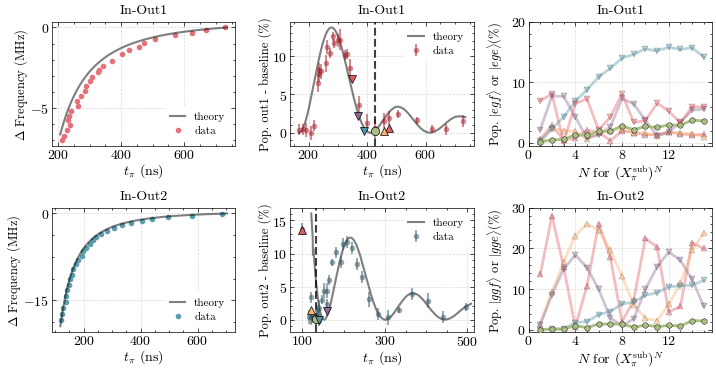

250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\swap_minima_calib_250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\swap_minima_calib_250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21.svg


In [209]:
saveplot = True 

labelsize = 10
keep_lens_21 = [0, 1, 2, 4, 5, 6]
good_ilen_21 = 2

# keep_lens_31 = [0, 1, 2, 3, 4, 5] #, 5, 6]
# good_ilen_31 = 2
keep_lens_31 = [0, 1, 2, 3, 4] #, 5, 6]
good_ilen_31 = 2

opt_len_12 = 0.2130
# opt_len_13 = 0.1536
opt_len_13 = 0.067

color_cycle = ['#e15b64', '#fbb26d', '#abbd83', '#5296a5', '#8d6b94']

color_cycle_21 = color_cycle
# start_color = "#f9dcdf"
# mid_color = "#e15b64"
# end_color = "#f9dcdf"
# color_cycle_21 = color_gradient(start_hex=start_color, end_hex=mid_color, steps=good_ilen_21 + 1) + color_gradient(start_hex=mid_color, end_hex=end_color, steps=len(keep_lens_21) - good_ilen_21 + 1)[1:]
marker_cycle_21 = ["^"]*(good_ilen_21) + ["o"] + ["v"]*(len(keep_lens_21) - good_ilen_21 - 1)

color_cycle_31 = color_cycle
# start_color = "#d4e7ed"
# mid_color = "#5296a5"
# end_color = "#d4e7ed"
# color_cycle_31 = color_gradient(start_hex=start_color, end_hex=mid_color, steps=good_ilen_31 + 1) + color_gradient(start_hex=mid_color, end_hex=end_color, steps=len(keep_lens_31) - good_ilen_31 + 1)[1:]
marker_cycle_31 = ["^"]*(good_ilen_31) + ["o"] + ["v"]*(len(keep_lens_31) - good_ilen_31 - 1)

color_dict = {'q1q3_right': '#5b9faeff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e5717aff', 'q1q2_wrong': '#a31f29ff'}

fig, axes = plt.subplots(2, 3, figsize=(8.0, 4.0), sharey=False, gridspec_kw={'width_ratios':[1, 1, 1]})
plt.subplots_adjust(hspace=0.5) 
plt.subplots_adjust(wspace=0.3) 


#==============#
# plot the stark shift check

x12_th = t_vec_12
x12_th_alt = 1/(2*t_vec_12)
y12_th = 1e3*np.array(w_vec_12/2/np.pi)
x12_exp = len_q1q2*1e3*2
y12_exp = freq_q1q2

x13_th = t_vec_13
x13_th_alt = 1/(2*t_vec_13)
y13_th = 1e3*np.array(w_vec_13/2/np.pi)
x13_exp = len_q1q3*1e3*2
y13_exp = freq_q1q3

idx_12_start = np.argmin(np.abs(x12_exp[0] - x12_th))
idx_12_stop = np.argmin(np.abs(x12_exp[-1] - x12_th))

idx_13_start = np.argmin(np.abs(x13_exp[0] - x13_th))
idx_13_stop = np.argmin(np.abs(x13_exp[-1] - x13_th))


ax = axes[0, 0]
plt.sca(ax)
ax.set_title("In-Out1", size=labelsize)
plt.grid(which='major')
ax.plot(x12_th[idx_12_start:idx_12_stop], y12_th[idx_12_start:idx_12_stop] - y12_th[idx_12_start], alpha=0.5, color='black', label='theory', zorder=10)
ax.errorbar(x12_exp[:-3], y12_exp[:-3] - y12_exp[0], fmt='o', color=color_dict['q1q2_right'], label='data')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_ylabel('$\Delta$ Frequency (MHz)', labelpad=0.3)
ax.set_yticks([-5, 0])
# ax.set_yticks([5880, 5885])
ax.set_xticks([200, 400, 600])
ax.legend()

ax = axes[1, 0]
plt.sca(ax)
ax.set_title("In-Out2", size=labelsize)
plt.grid(which='major')
ax.plot(x13_th[idx_13_start:idx_13_stop], y13_th[idx_13_start:idx_13_stop] - y13_th[idx_13_start], alpha=0.5, color='black', label='theory', zorder=10)
ax.errorbar(x13_exp[1:-1], y13_exp[1:-1] - y13_exp[0], fmt='o', color=color_dict['q1q3_right'], label='data')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xticks([200, 400, 600])
ax.set_ylabel('$\Delta$ Frequency (MHz)', labelpad=0.3)
ax.set_yticks([-15, 0])
# ax.set_yticks([5130, 5140])
ax.legend()


#==============#

leakage_pops_21 = []
for i_leak in keep_lens_21:
    leakage_pops_21.append(pop_Bgf_21[i_leak][np.argwhere(depths_21[i_leak] == 1)[0][0]])
    # leakage_pops_21.append(np.max(pop_Bgf_21[i_leak]))
leakage_pops_21 = np.array(leakage_pops_21)
leakage_pops_31 = []
for i_leak in keep_lens_31:
    # leakage_pops_31.append(pop_Bgf_31[i_leak][np.argwhere(depths_31[i_leak] == 1)[0][0]])
    # leakage_pops_31.append(np.max(pop_Bgf_31[i_leak]))
    leakage_pops_31.append(pop_Bgf_31_fast[i_leak][np.argwhere(depths_31_fast[i_leak] == 1)[0][0]])
leakage_pops_31 = np.array(leakage_pops_31)

#==============#
#  plot the minima experiment

x12_th = t_vec_12
x12_th_alt = 1/(2*t_vec_12)
baseline_12 = 0.06
y12_th = np.array(pop_q2)
x12_exp = len_q1q2_combo*1e3*2
y12_exp = e_pop_avg_q1q2[::-1]
y12_exp = np.array(e_pop_avg_q1q2) - baseline_12
y12_err = e_pop_std_q1q2[::-1]

x13_th = t_vec_13
x13_th_alt = 1/(2*t_vec_13)
baseline_13 = 0.045
y13_th = np.array(pop_q3)
x13_exp = len_q1q3_combo*1e3*2
y13_exp = e_pop_avg_q1q3[::-1]
y13_exp = np.array(e_pop_avg_q1q3) - baseline_13
y13_err = e_pop_std_q1q3[::-1]

idx_12_start = np.argmin(np.abs(x12_exp[0] - x12_th))
idx_12_stop = np.argmin(np.abs(x12_exp[-1] - x12_th))

# idx_13_start = np.argmin(np.abs(x13_exp[0] - x13_th))
idx_13_start = 12
idx_13_stop = np.argmin(np.abs(x13_exp[-1] - x13_th)) + 45
# idx_13_stop = -1


ax = axes[0, 1]
plt.sca(ax)
ax.set_title("In-Out1", size=labelsize)
plt.grid(which='major')
ax.plot(x12_th[idx_12_start:idx_12_stop], 100*y12_th[idx_12_start:idx_12_stop], alpha=0.5, color='black', label='theory')
# ax.plot(x12_exp, 100*y12_exp, 'o', alpha=0.2, markeredgewidth=0.0, markersize=4, color='k', label='data')
ax.errorbar(x12_exp, 100*y12_exp, 100*y12_err, fmt='o', alpha=0.5, markeredgewidth=0.0, markersize=4, color=color_dict['q1q2_wrong'], label='data')
for i, i_leak in enumerate(keep_lens_21):
    print("q2/q1 pi/2 length", leakage_lens_21[i_leak])
    ax.plot(2*1e3*leakage_lens_21[i_leak], 100*leakage_pops_21[i], marker_cycle_21[i % len(marker_cycle_21)], markeredgewidth=0.5, markeredgecolor='k', markersize=6, color=color_cycle_21[i % len(color_cycle_21)], zorder=10)
ax.axvline(2*1e3*opt_len_12, color='black', linestyle='--', alpha=0.75)
# ax[0, 1].set_xlabel('Time (ns)')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_ylabel('Pop. out1 - baseline (%)', labelpad=0.3)
ax.set_xticks([200, 400, 600])
ax.legend()

ax = axes[1, 1]
plt.sca(ax)
ax.set_title("In-Out2", size=labelsize)
plt.grid(which='major')
ax.plot(x13_th[idx_13_start:idx_13_stop], 100*y13_th[idx_13_start:idx_13_stop], alpha=0.5, color='black', label='theory')
ax.errorbar(x13_exp[1:], 100*y13_exp[1:], 100*y13_err[1:], fmt='o', alpha=0.5, markeredgewidth=0.0, markersize=4, color=color_dict['q1q3_wrong'], label='data')
# ax.plot(x13_exp[1:], 100*y13_exp[1:], 'o', alpha=0.2, markeredgewidth=0.0, markersize=4, color='k', label='data')
for i, i_leak in enumerate(keep_lens_31):
    print("q3/q1 pi/2 length", leakage_lens_31_fast[i_leak])
    ax.plot(2*1e3*leakage_lens_31_fast[i_leak], 100*leakage_pops_31[i], marker_cycle_31[i % len(marker_cycle_31)], markeredgewidth=0.5, markeredgecolor='k', markersize=6, color=color_cycle_31[i % len(color_cycle_31)], zorder=10)
ax.axvline(2*1e3*opt_len_13, color='black', linestyle='--', alpha=0.75)
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xlim(None, 515)
ax.set_xticks([100, 300, 500])
ax.set_ylabel('Pop. out2 - baseline (%)', labelpad=0.3)
ax.legend()

#==============#
#  plot the leakage error amp

# print(np.array(pop_Bgf_21).shape)
ax = axes[0, 2]
plt.sca(ax)
plt.grid(which='major')
plt.title("In-Out1", size=labelsize)
for i, i_leak in enumerate(keep_lens_21):
    if i == good_ilen_21:
        zorder = 10
        alpha = 1.0
    else:
        zorder = None
        alpha = 0.4
    plt.plot(depths_21[i_leak][:15], 100*pop_Bgf_21[i_leak][:15], marker_cycle_21[i % len(marker_cycle_21)]+'-',alpha=alpha, markeredgewidth=0.3, markeredgecolor='k', markersize=4, linewidth=2.0, color=color_cycle_21[i % len(color_cycle_21)], zorder=zorder)
plt.ylabel(f"Pop. $|{get_bad(2)}gf\\rangle$ or $|{get_bad(2)}ge\\rangle$(%)")
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(2)}eg\\rangle-|{get_good(2)}gf\\rangle"+"})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax.set_xticks(np.arange(0, 16, 4))
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.ylim(-0.5, 20.0)

# print(np.array(pop_Bgf_31).shape)
ax = axes[1, 2]
plt.sca(ax)
plt.title("In-Out2", size=labelsize)
plt.grid(which='major')
for i, i_leak in enumerate(keep_lens_31):
    if i == good_ilen_31:
        zorder = 10
        alpha = 1.0
    else:
        zorder = None
        alpha = 0.4
    # plt.plot(depths_31[i_leak][:15], 100*pop_Bgf_31[i_leak][:15], marker_cycle_31[i % len(marker_cycle_31)]+'-',alpha=alpha, markeredgewidth=0.3, markeredgecolor='k', markersize=4, linewidth=2.0, color=color_cycle_31[i % len(color_cycle_31)], zorder=zorder)
    plt.plot(depths_31_fast[i_leak][:15], 100*pop_Bgf_31_fast[i_leak][:15], marker_cycle_31[i % len(marker_cycle_31)]+'-',alpha=alpha, markeredgewidth=0.3, markeredgecolor='k', markersize=4, linewidth=2.0, color=color_cycle_31[i % len(color_cycle_31)], zorder=zorder)
plt.ylabel(f"Pop. $|{get_bad(3)}gf\\rangle$ or $|{get_bad(3)}ge\\rangle$(%)")
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(3)}eg\\rangle-|{get_good(3)}gf\\rangle"+"})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xticks(np.arange(0, 16, 4))
plt.ylim(-0.5, 30)



plt.show()

filepaths_str = folder[5:] + "_" + '_'.join([path[:5] for path in leakage_31_paths]) + "_31"
filepaths_str = filepaths_str + "_" + '_'.join([path[:5] for path in leakage_21_paths]) + "_21"

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'swap_minima_calib_{filepaths_str}.pdf')
print("Saving", savename)
if saveplot: fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'swap_minima_calib_{filepaths_str}.svg')
print("Saving", savename)
if saveplot: fig.savefig(savename)

## Pi/pi probing good/bad states

In [47]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)



Data dir S:\QRAM\qram_4QR2\data\data_250119


In [49]:
leakage_paths = dict(
    # bad_31="00008_leakage_EgGf_qubit31",
    # good_31="00016_leakage_EgGf_qubit31",
    bad_31="00032_leakage_EgGf_qubit31",
    good_31="00027_leakage_EgGf_qubit31",
    bad_21="00004_leakage_EgGf_qubit21",
    good_21="00009_leakage_EgGf_qubit21", 
)

In [50]:
data_dict = dict()

for name in leakage_paths.keys():
    print("Processing", leakage_paths[name])
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_paths[name]+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    print(rbprog.cfg.expt)
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    data_dict[name] = data

Processing 00032_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00032_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'reps': 4000, 'reps_f': 6000, 'loops': 10, 'gate_char': None, 'qubits': [0, 1, 3], 'qDrive': 3, 'singleshot_reps': 10000, 'post_process': 'threshold', 'test_leakage': True, 'wrong_init': True, 'measure_f_only': False, 'measure_f': [3], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'ground_state_init': False, 'variations': 1, 'singleshot_reps_f': 10000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00027_leakage_EgGf_qubit31
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00027_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'reps': 8000, 'reps_f': 12000, 'loops': 3, 'gate_char': None, 'qubits': [0, 1, 3], 'qDrive': 3, 'singleshot_reps': 30000, 'post_process': 'threshold', 'test_leakage': True, 'wrong_init': False, 'measure_f_only': False, 'measure_f': [3], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'ground_state_init': False, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Processing 00004_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00004_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105], 'reps': 40000, 'reps_f': 100000, 'loops': 5, 'gate_char': None, 'qubits': [0, 1, 2], 'qDrive': 2, 'singleshot_reps': 30000, 'post_process': 'threshold', 'measure_f_only': False, 'measure_f': [2], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'test_leakage': True, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00009_leakage_EgGf_qubit21
Failed to locate the nameserver
S:\QRAM\qram_4QR2\data\data_250119\00009_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'reps': 40000, 'reps_f': 100000, 'loops': 2, 'gate_char': None, 'qubits': [0, 1, 2], 'qDrive': 2, 'singleshot_reps': 30000, 'post_process': 'threshold', 'test_leakage': True, 'wrong_init': False, 'measure_f_only': False, 'measure_f': [2], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
# save the data
savename = os.path.join(swap_leak_save_path, f'swap_leakage_data_{folder}_31_21.npz') 
print("Saving", savename)
np.savez(savename, data_dict=data_dict)

Saving S:\Connie\experiments\qram_tprocv1_expts\data_plot\SWAP_leakage\swap_leakage_data_data_250119_31_21.npz


In [57]:
data_dict

{'bad_31': {'angles_f_loops': array([[ -84.89474683,   38.64914052,    0.        , -148.40377962],
         [ -86.26190559,   40.89138596,    0.        ,   15.47830334],
         [ -88.86524875,   40.20935349,    0.        ,  -46.06636975],
         [ -91.1475247 ,   41.76453571,    0.        ,   19.31075048],
         [ -91.78595492,   40.66839632,    0.        ,  -55.95088502],
         [ -93.71328612,   39.95750884,    0.        ,  146.78322066],
         [ -95.45708091,   41.9505683 ,    0.        ,  177.599801  ],
         [ -96.57038529,   38.77950132,    0.        ,  -83.06254592],
         [ -98.13778414,   40.83434011,    0.        , -112.09228562],
         [ -99.56717268,   38.84353822,    0.        ,  160.93409393]]),
  'angles_loops': array([[ -89.94092685,   79.05330073,    0.        , -149.17145897],
         [ -91.61487213,   79.13620077,    0.        , -129.17140555],
         [ -92.93559292,   79.64806347,    0.        ,  119.28343617],
         [ -94.93041086,   79.5

In [170]:
def get_bad(qDrive):
    if qDrive == 2: return "e"
    if qDrive == 3: return "g"
    return None

def get_good(qDrive):
    if qDrive == 3: return "e"
    if qDrive == 2: return "g"
    return None

In [171]:
pop_dict = dict()
depths_dict = dict()

for name in data_dict.keys():
    data = data_dict[name]
    if "bad" in name:
        # pop_dict[name] = data["popln_Bgf_avg"]
        pop_dict[name] = data["popln_Bgf_avg"] + data["popln_Bge_avg"]
        # pop_dict[name] = data["popln_Bgf_avg"] + data["popln_Beg_avg"]
    else:
        pop_dict[name] = data["popln_Ggf_avg"]
        # pop_dict[name] = data["popln_Ggf_avg"] + data["popln_Gge_avg"]
        # pop_dict[name] = data["popln_Ggf_avg"] + data["popln_Geg_avg"]
        # pop_dict[name] = data["popln_Bgg_avg"]
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_dict[name] = unique_depths
    print(name, unique_depths)

bad_31 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
good_31 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
bad_21 [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]
good_21 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Total leakage after 15.0 gates (%) bad_21 3.6236818335002785
Leakage per gate (%) bad_21 0.24157878890001858
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Total leakage after 15.0 gates (%) bad_31 2.2094760250266807
Leakage per gate (%) bad_31 0.14729840166844538


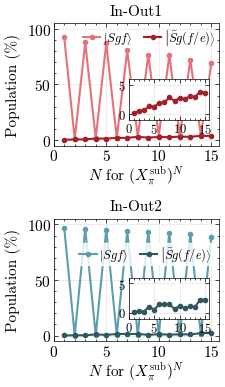

250119_bad_31_00032_good_31_00027_bad_21_00004_good_21_00009
Saving S:\QRAM\qram_4QR2\plots\paper\rb\leakage_error_amp_250119_bad_31_00032_good_31_00027_bad_21_00004_good_21_00009.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\rb\leakage_error_amp_250119_bad_31_00032_good_31_00027_bad_21_00004_good_21_00009.svg


In [185]:
darkmode = False

from matplotlib.scale import FuncScale
from matplotlib.ticker import AutoMinorLocator

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use('S:\Connie\prx.mplstyle')
if darkmode: plt.style.use('dark_background')

color_dict = {'good_31': '#5b9faeff', 'bad_31': '#2f5760ff', 'good_21': '#e5717aff', 'bad_21': '#a31f29ff'}

labelsize = 11

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Custom transformation function
def custom_transform(x):
    new_x = x.astype(np.float64)
    for i, xx in enumerate(x):
        if xx < 2:
            new_x[i] *= 50 / 2  # Compressing factor for values between 0 and 2
        else:
            new_x[i] = 50 + (xx - 2) * (1 + 50 / 98)  # Linear scaling from 2 to 100
    return new_x

# Inverse transformation function
def inverse_transform(x):
    new_x = x.astype(np.float64)
    for i, xx in enumerate(x):
        if xx < 2:
            new_x[i] *= 2 / 50  # Compressing factor for values between 0 and 2
        else:
            new_x[i] = (xx - 50) / (1 + 50 / 98) + 2 # Linear scaling from 2 to 100
    return new_x

fig, ax = plt.subplots(2, 1, figsize=(2.0, 4.1), sharey=False)
plt.subplots_adjust(hspace=0.6) 
plt.subplots_adjust(wspace=0.3) 

plt.sca(ax[0])
plt.grid(which='major')
plt.title("In-Out1", fontsize=labelsize)

name = "good_21"
# label = f"{get_good(2)}gf"
label = "$\\left|Sgf\\right>$"
plt.plot(depths_dict[name], 100*pop_dict[name], 'o-', label=label, color=color_dict[name])
name = "bad_21"
# label = f"{get_bad(2)}gf"
label = "$\\left|\\bar{S}g(f/e)\\right>$"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', label=label, color=color_dict[name])
plt.ylabel(f"Population (%)", fontsize=labelsize)
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(2)}eg\\rangle-|{get_good(2)}gf\\rangle"+"})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|Seg\\rangle-|Sgf\\rangle"+"})^N$"
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax[0].set_xticks(np.arange(0, 16, 5))
ax[0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
# ax[0].set_yscale(FuncScale(ax[0], (custom_transform, inverse_transform)))
# yticks = [0, 1, 2, 50, 100]
# ax[0].set_yticks(yticks)
# # ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[0].yaxis.set_minor_locator(plt.NullLocator())
plt.ylim(-5, 105)
# plt.yscale("log")
# plt.ylim(-0.5, 2)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.06), ncol=2, handletextpad=0.2, frameon=False, fontsize=labelsize-2, framealpha=0.75)

# Inset
# left, bottom, width, height = [0.62, 0.71, 0.4, 0.1]
left, bottom, width, height = [0.50, 0.715, 0.4, 0.1]
ax0_1 = fig.add_axes([left, bottom, width, height])
name = "bad_21"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', color=color_dict[name])
print(f"Total leakage after {depths_dict[name][14]} gates (%)", name, 100*pop_dict[name][14])
print("Leakage per gate (%)", name, 100*pop_dict[name][14] / depths_dict[name][14])
plt.ylim(-1.0, 6.0)
# plt.xlim(0.35*depths_dict[name][14], None)
plt.grid(which='major')
ax0_1.set_yticks([0, 5])
ax0_1.set_xticks([0, 5, 10, 15])
# ax0_1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0_1.yaxis.set_minor_locator(plt.NullLocator())
# ax0_1.xaxis.set_minor_locator(plt.NullLocator())
ax0_1.tick_params(axis="both", which="both", labelsize=labelsize-2, pad=2)
# ax0_1.yaxis.tick_right()
# ax0_1.xaxis.tick_top()

plt.sca(ax[1])
plt.title("In-Out2", fontsize=labelsize)
plt.grid(which='major')
name = "good_31"
# label = f"{get_good(3)}gf"
label = "$\\left|Sgf\\right>$"
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', label=label, color=color_dict[name])
name = "bad_31"
# label = f"{get_bad(3)}gf"
# label = "$\\left|\\bar{S}gf\\right>$ or\n$\\left|\\bar{S}ge\\right>$"
label = "$\\left|\\bar{S}g(f/e)\\right>$"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', label=label, color=color_dict[name])
plt.ylabel(f"Population (%)", fontsize=labelsize)
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(3)}eg\\rangle-|{get_good(3)}gf\\rangle"+"})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|Seg\\rangle-|Sgf\\rangle"+"})^N$"
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax[1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax[1].set_xticks(np.arange(0, 16, 5))
# plt.ylim(-0.5, 105)
# plt.ylim(-0.5, 2)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.85), ncol=2, borderpad=0.05, handletextpad=0.2, frameon=True, fontsize=labelsize-2, framealpha=0.8)
# plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.06), ncol=2, borderpad=0.05, handletextpad=0.2, frameon=False, fontsize=labelsize-2, framealpha=0.8)
ax[1].sharey(ax[0])
# plt.yscale('log')

# Inset
# left, bottom, width, height = [0.62, 0.71, 0.4, 0.1]
left, bottom, width, height = [0.50, 0.230, 0.4, 0.1]
ax0_1 = fig.add_axes([left, bottom, width, height])
name = "bad_31"
# label = f"{get_bad(3)}gf"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', color=color_dict[name])
print(f"Total leakage after {depths_dict[name][14]} gates (%)", name, 100*pop_dict[name][14])
print("Leakage per gate (%)", name, 100*pop_dict[name][14] / depths_dict[name][14])
plt.ylim(-1.0, 6.0)
# plt.xlim(0.35*depths_dict[name][14], None)
plt.grid(which='major')
ax0_1.set_yticks([0, 5])
ax0_1.set_xticks([0, 5, 10, 15])
# ax0_1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0_1.yaxis.set_minor_locator(plt.NullLocator())
# ax0_1.xaxis.set_minor_locator(plt.NullLocator())
ax0_1.tick_params(axis="both", which="both", labelsize=labelsize-2, pad=2)
# ax0_1.yaxis.tick_right()
# ax0_1.xaxis.tick_top()

plt.show()

filepaths_str = folder[5:] + "_" + '_'.join([name + "_" + leakage_paths[name][:5] for name in leakage_paths.keys()])
filepaths_str += '_dark' if darkmode else ''

print(filepaths_str)

savename = os.path.join(save_plot_path, 'rb', f'leakage_error_amp_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename, transparent=False)

savename = os.path.join(save_plot_path, 'rb', f'leakage_error_amp_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename, transparent=False)

# Bloch sphere for MLE with ZZ

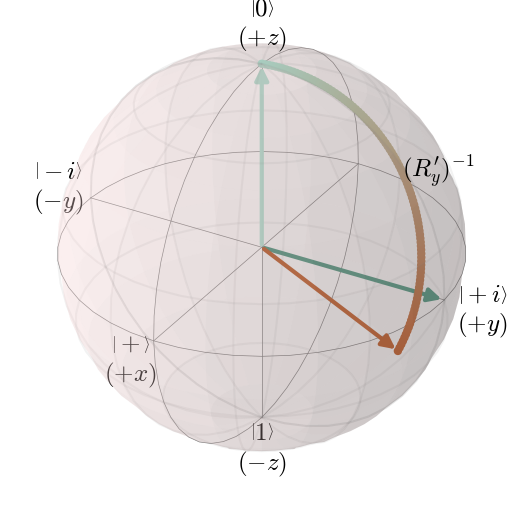

Saving S:\QRAM\qram_4QR2\plots\paper\supmat\zz_correction_trajectory.svg
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\zz_correction_trajectory.pdf


In [674]:
plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use('S:\Connie\prx.mplstyle')

import qutip_qip.operations as qip
b = qt.Bloch()
b.frame_alpha = 0.1
b.frame_width = 0.5
# b.vector_color = ["#e6a79f", "#b53e2f" , "#518a77"]
b.vector_color = ["#a8cdc0", "#ae592d" , "#518a77"]
b.point_color = color_gradient(b.vector_color[0], b.vector_color[1], 100)
b.zlabel = ['$\\left|0\\right>$\n($+z$)', '$\\left|1\\right>$\n($-z$)'] 
b.xlabel = ['$\\left|+\\right>$\n($+x$)', ""] #, '$\left|-\\right>$\n($-x$)']
b.ylabel = ['$\\left|+i\\right>$\n($+y$)', '$\\left|-i\\right>$\n($-y$)']
fontsize = 18
b.font_size = fontsize

# x = (qt.basis(2,0)+(1+0j)*qt.basis(2,1)).unit()
# y = (qt.basis(2,0)+(0+1j)*qt.basis(2,1)).unit()
z = (qt.basis(2,0)+(0+0j)*qt.basis(2,1)).unit()

# b.add_states(x)
# b.add_states(y)
b.add_states(z)
# b.show()

def good_rot(theta):
    return qip.rx(theta)

def bad_rot(theta, err_x=0.1, err_y=0.2, err_z=0.5, ):
    # return qt.qip.rx(theta)
    return qip.rotation((1+err_x)*qip.x_gate() + err_z*qip.z_gate() + err_y*qip.y_gate(), theta)

def get_traj(U_rot_func, theta_sweep, init_state):
    traj_vecs = [(U_rot_func(theta)*init_state)*(U_rot_func(theta)*init_state).dag() for theta in theta_sweep]
    traj_xs = [qt.expect(qt.sigmax(), vec) for vec in traj_vecs]
    traj_ys = [qt.expect(qt.sigmay(), vec) for vec in traj_vecs]
    traj_zs = [qt.expect(qt.sigmaz(), vec) for vec in traj_vecs]
    return traj_xs, traj_ys, traj_zs 

# b = qt.Bloch()

theta_sweep = np.linspace(0, np.pi/2, 100)

# bad_traj_X_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, x)
# bad_traj_Y_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, y)
bad_traj_Z_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, z)

good_traj_Z_pnts = get_traj(good_rot, theta_sweep, z)

# print(good_traj_xs)

# print(bad_traj_xs)

# b.add_points(bad_traj_X_pnts, meth='l')
# b.add_points(bad_traj_Y_pnts, meth='l')
b.add_points(bad_traj_Z_pnts, meth='m')

b.vector_style = '-|>'
# b.add_states(bad_rot(theta_sweep[-1])*x)
# b.add_states(bad_rot(theta_sweep[-1])*y)

final_bad_state = bad_rot(theta_sweep[-1]).dag()*z
final_good_state = good_rot(theta_sweep[-1]).dag()*z
b.add_states(final_bad_state)
b.add_states(final_good_state)
# b.add_annotation(final_bad_state, "$(R_x')^{-1} \\sigma_z (R_y')$", fontsize=15, verticalalignment='top')
b.add_annotation((final_bad_state + z).unit(), "$(R_y')^{-1}$", fontsize=fontsize, horizontalalignment='left', zorder=10)

b.show()

fig = b.fig
# fig.tight_layout()

savename = os.path.join(save_plot_path, 'supmat', f'zz_correction_trajectory.svg')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'zz_correction_trajectory.pdf')
print("Saving", savename)
fig.savefig(savename)

# RB for other swap length

In [ ]:
file_name_q1q2_short = '00035_rb_EgGf_qubit21.h5'
file_name_q1q2_long = '00005_rb_EgGf_qubit21.h5'

file_name_q1q3_short = '00014_rb_EgGf_qubit31.h5'
file_name_q1q3_long = '00015_rb_EgGf_qubit31.h5'

folder = 'data_250119'

filenames_short_long = dict(
    q1q2_short=file_name_q1q2_short,
    q1q2_long=file_name_q1q2_long,
    q1q3_short=file_name_q1q3_short,
    q1q3_long=file_name_q1q3_long
)

In [ ]:
data_short_long = dict()

for short_long in filenames_short_long.keys():
    print("Processing", filenames_short_long[short_long])
    rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, filenames_short_long[short_long]+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    data_short_long[short_long] = data

Processing 00002_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00002_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_23172\1939458940.py: 13

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00003_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00003_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00004_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00004_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00005_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00005_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00011_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00011_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00012_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00012_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00013_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00013_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
def fit(x, p, B, A):
    return B*p**x + A

In [ ]:
for q in [2, 3]:
    filename = 'short_' + filenames_short_long[f'q1q{q}_short'][:5] + '_' + 'long_' + filenames_short_long[f'q1q{q}_long'][:5] + f'_merged_rb_EgGf_qubit{q}1.npz'
    full_filename = os.path.join(data_dir, folder, filename)
    print("Filename", full_filename)

    # # SAVE THE DATA
    # data_short = data_short_long[f'q1q{q}_short']
    # data_long = data_short_long[f'q1q{q}_long']

    # xpts_short = data_short['xpts']
    # xpts_long = data_long['xpts']

    # pop_short = np.asarray(data_short['poplns_2q'])
    # pop_long = np.asarray(data_long['poplns_2q'])

    # np.savez(full_filename, pop_short=pop_short, pop_long=pop_long, xpts_short=xpts_short, xpts_long=xpts_long)
    # print('saving', full_filename)

In [ ]:
# reload the data
data = np.load(full_filename)
pop_13 = data['pop_13']
xpts = data['xpts']
n = len(np.asarray(xpts)[0])

pop_dict_13 = {}
pop_dict_13['avg'] = {}
pop_dict_13['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_13[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
    pop_dict_13['avg'][state] = _pop_post_avg
    pop_dict_13['err'][state] = _pop_post_err

    # pop_dict_13['avg'][state] = pop_13[:, :, idx].mean(axis=1)
    # pop_dict_13['err'][state] = pop_13[:, :, idx].std(axis=1)/np.sqrt(n)
    x_rb_13 = np.unique(xpts)
print(xpts) 

[[  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 300]
 [  1  15  30  45  60  75  90 105 120 135 150 200 250 30

In [ ]:
# define the subspace population and its error
popln_subspace_avg_13=  np.sum([pop_dict_13['avg'][state] for state in state_subspace_13], axis=0)
popln_subspace_err_13 = np.std([pop_dict_13['err'][state] for state in state_subspace_13], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_13[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_13:
        _pop_temp += pop_13[:, :, idx]
popln_subspace_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_13 = pop_dict_13['avg']['eeg']
popln_eg_renorm_13 = popln_eg_13/popln_subspace_avg_13

idx_eg = state_name_str.index('eeg')
_pop_temp = pop_13[:, :, idx_eg]
popln_eg_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('eeg')
idx_gf = state_name_str.index('egf')
_pop_temp = pop_13[:, :, idx_eg]/(pop_13[:, :, idx_eg] + pop_13[:, :, idx_gf])
popln_eg_renorm_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_13 = 1 - np.sum([pop_dict_13['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_13[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_13[:, :, idx]
popln_not_erase_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

In [ ]:
# _pop_temp = np.zeros_like(pop_13[:, :, 0])

# for idx, state in enumerate(state_name_str):
#     if state in state_subspace_13:
#         _pop_temp += pop_13[:, :, idx]
# popln_subspace_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# popln_subspace_err_13 = np.zeros(pop_13[:, :, 0].shape[0])
# _pop_temp = np.zeros_like(pop_13[:, :, 0])
# for idx, state in enumerate(state_name_str):
#     if state in state_subspace_13:
#         _pop_temp += pop_13[:, :, idx]
        
# for i in range(_pop_temp.shape[0]):
#     pop_slice = _pop[i, :]
#     idx_post = np.where(pop_slice < 1)
#     _pop_post = pop_slice[idx_post]
#     popln_subspace_err_13[i] = _pop_post.std()/np.sqrt(len(_pop_post))
         
# # popln_subspace_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# # define the subspace population and its error
# popln_subspace_avg_13 = np.sum([pop_dict_13['avg'][state] for state in state_subspace_13], axis=0)
# popln_subspace_err_13 = np.std([pop_dict_13['err'][state] for state in state_subspace_13], axis=0)/np.sqrt(n)


# # _pop_temp = np.zeros_like(pop_13[:, :, 0])
# # for idx, state in enumerate(state_name_str):
# #     if state in state_subspace_13:
# #         _pop_temp += pop_13[:, :, idx]
# # popln_subspace_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# popln_subspace_err_13 = np.zeros(pop_13[:, :, 0].shape[0])
# _pop_temp = np.zeros_like(pop_13[:, :, 0])
# for idx, state in enumerate(state_name_str):
#     if state in state_subspace_13:
#         _pop_temp += pop_13[:, :, idx]
        
# for i in range(_pop_temp.shape[0]):
#     pop_slice = _pop[i, :]
#     idx_post = np.where(pop_slice < 1)
#     _pop_post = pop_slice[idx_post]
#     popln_subspace_err_13[i] = _pop_post.std()/np.sqrt(len(_pop_post))
            
            
# # define the eg/(eg+gf) and its error
# popln_eg_13 = pop_dict_13['avg']['eeg']
# popln_eg_renorm_13 = popln_eg_13/popln_subspace_avg_13

# idx_eg = state_name_str.index('eeg')
# _pop_temp = pop_13[:, :, idx_eg]
# popln_eg_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# idx_eg = state_name_str.index('eeg')
# idx_gf = state_name_str.index('egf')
# _pop_temp = pop_13[:, :, idx_eg]/(pop_13[:, :, idx_eg] + pop_13[:, :, idx_gf])
# popln_eg_renorm_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)



# popln_not_erase_13 = 1 - np.sum([pop_dict_13['avg'][state] for state in state_erasure], axis=0)
# _pop_temp = np.zeros_like(pop_13[:, :, 0])
# for idx, state in enumerate(state_name_str):
#     if state in state_erasure:
#         _pop_temp += pop_13[:, :, idx]
# popln_not_erase_err_13 = np.std(_pop_temp, axis=1)/np.sqrt(n)


#### Import the q1q2 data

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
temp_data, attrs = prev_data(file_path_q1q2)
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
rbprog.calib_order = attrs['calib_order']

data_12 = rbprog.analyze(fit=True)

S:/QRAM/qram_4QR2/data//data_250119/00012_rb_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.  15.  30.  45.  60.  75.  90. 105. 120. 135.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_6796\3210409008.py: 17

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

fit1 p1, a, offset [0.98756766 0.88436174 0.06129387]
fit2 a0, b0, c0, p2 [4.33460855e-18 4.93767497e-01 4.11987017e-01 9.48838807e-01]


In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
temp_data, attrs = prev_data(file_path_q1q2_bis)
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
rbprog.calib_order = attrs['calib_order']
state_name_str = rbprog.calib_order

data_12_bis = rbprog.analyze(fit=True)

S:/QRAM/qram_4QR2/data//data_250119/00013_rb_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[150. 200. 250. 300.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_6796\3210409008.py: 17

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

fit1 p1, a, offset [0.99118436 0.80062904 0.00365122]
fit2 a0, b0, c0, p2 [3.53081185e-16 3.40098150e-01 4.09463389e-01 7.37022855e-01]


 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py: 1010

In [ ]:
filename = file_name_q1q2[:5] + '_' + file_name_q1q2_bis[:5] + '_merged_rb_EgGf_qubit21.npz'
full_filename = os.path.join(data_dir, folder, filename)

# # SAVE THE DATA
# _xpts = data_12['xpts']
# _xpts_bis = data_12_bis['xpts']
# z = 1.96

# # pop_13 = np.asarray(file_q1q3['poplns_2q'])
# pop_12 = np.asarray(data_12['poplns_2q'])
# pop_12_bis = np.asarray(data_12_bis['poplns_2q'])
# pop_12_merged = np.concatenate((pop_12, pop_12_bis), axis=0)
# xpts_merged = np.concatenate((_xpts, _xpts_bis), axis=1)

# # save the data 
# print('saving', full_filename)
# np.savez(full_filename, pop_12=pop_12_merged, xpts=xpts_merged)

In [ ]:
# reload the data
data = np.load(full_filename)
pop_12 = data['pop_12']
xpts = data['xpts']
n= len(np.asarray(xpts)[0])

pop_dict_12 = {}
pop_dict_12['avg'] = {}
pop_dict_12['err'] = {}
for idx, state in enumerate(state_name_str):
    # do the average and error postselected where pop_13 should be < 1
    
    _pop = pop_12[:, :, idx]
    _pop_post_avg = np.zeros(_pop.shape[0])
    _pop_post_err = np.zeros(_pop.shape[0])
    for i in range(_pop.shape[0]):
        pop_slice = _pop[i, :]
        idx_post = np.where(pop_slice < 1)
        _pop_post = pop_slice[idx_post]
        _pop_post_avg[i] = _pop_post.mean()
        _pop_post_err[i] = _pop_post.std()/np.sqrt(len(_pop_post))
        
        
    pop_dict_12['avg'][state] = _pop_post_avg
    pop_dict_12['err'][state] = _pop_post_err
    
    x_rb_12 = np.unique(xpts)

In [ ]:
# define the subspace population and its error
popln_subspace_avg_12=  np.sum([pop_dict_12['avg'][state] for state in state_subspace_12], axis=0)
popln_subspace_err_12 = np.std([pop_dict_12['err'][state] for state in state_subspace_12], axis=0)/np.sqrt(n)


_pop_temp = np.zeros_like(pop_12[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_subspace_12:
        _pop_temp += pop_12[:, :, idx]
popln_subspace_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)


# define the eg/(eg+gf) and its error
popln_eg_12 = pop_dict_12['avg']['geg']
popln_eg_renorm_12 = popln_eg_12/popln_subspace_avg_12

idx_eg = state_name_str.index('geg')
_pop_temp = pop_12[:, :, idx_eg]
popln_eg_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

idx_eg = state_name_str.index('geg')
idx_gf = state_name_str.index('ggf')
_pop_temp = pop_12[:, :, idx_eg]/(pop_12[:, :, idx_eg] + pop_12[:, :, idx_gf])
popln_eg_renorm_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)



popln_not_erase_12 = 1 - np.sum([pop_dict_12['avg'][state] for state in state_erasure], axis=0)
_pop_temp = np.zeros_like(pop_12[:, :, 0])
for idx, state in enumerate(state_name_str):
    if state in state_erasure:
        _pop_temp += pop_12[:, :, idx]
popln_not_erase_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

In [ ]:
# # xpts = file_q1q2['xpts']
# xpts = data_12['xpts']
# n = len(np.asarray(xpts)[0])
# z = 1.96

# # pop_12 = np.asarray(file_q1q2['poplns_2q'])
# pop_12 = np.asarray(data_12['poplns_2q'])

# pop_dict_12 = {}
# pop_dict_12['avg'] = {}
# pop_dict_12['err'] = {}
# for idx, state in enumerate(state_name_str):
#     pop_dict_12['avg'][state] = pop_12[:, :, idx].mean(axis=1)
#     pop_dict_12['err'][state] = pop_12[:, :, idx].std(axis=1)/np.sqrt(n)

# popln_subspace_avg_12 = np.sum([pop_dict_12['avg'][state] for state in state_subspace_12], axis=0)
# _pop_temp = np.zeros_like(pop_12[:, :, 0])
# for idx, state in enumerate(state_name_str):
#     if state in state_subspace_12:
#         _pop_temp += pop_12[:, :, idx]
# popln_subspace_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# popln_eg_12 = pop_dict_12['avg']['geg']
# popln_eg_renorm_12 = popln_eg_12/popln_subspace_avg_12

# idx_eg = state_name_str.index('geg')
# _pop_temp = pop_12[:, :, idx_eg]
# popln_eg_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# idx_eg = state_name_str.index('geg')
# idx_gf = state_name_str.index('ggf')
# _pop_temp = pop_12[:, :, idx_eg]/(pop_12[:, :, idx_eg] + pop_12[:, :, idx_gf])
# popln_eg_renorm_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# popln_not_erase_12 = 1 - np.sum([pop_dict_12['avg'][state] for state in state_erasure], axis=0)
# _pop_temp = np.zeros_like(pop_12[:, :, 0])
# for idx, state in enumerate(state_name_str):
#     if state in state_erasure:
#         _pop_temp += pop_12[:, :, idx]
# popln_not_erase_err_12 = np.std(_pop_temp, axis=1)/np.sqrt(n)

# x_rb_12 = np.unique(xpts)

# Get readout fidelity

In [71]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, verbose=True):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    if verbose: print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        if verbose: print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [78]:
num_tries = 30 # per qubit
fid_avg = False # calculate as (P(e|e) + P(g|g))/2

In [79]:
fid_qs = np.zeros(shape=(num_tries, 4))

## First get single shots from the 3q tomo for q0/2/3

In [80]:
start_i = 577
stop_i = start_i + num_tries - 1
assert stop_i <= 656

base_path = 'S:\\QRAM\\qram_4QR2\\data\\data_250119'
filename = 'QramProtocol3QTomo.h5'

saved_files = []
saved_data = []
saved_attrs = []

for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files.append(f'{base_path}\\00{i}_{filename}')

print(saved_files)

for file in tqdm(saved_files):
    data, attrs = prev_data(file, verbose=False)
    saved_data.append(data)
    saved_attrs.append(attrs)

print(saved_data[0].keys())
print(saved_attrs[0].keys())

['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00577_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00578_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00579_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00580_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00581_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00582_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00583_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00584_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00585_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00586_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00587_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00588_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00589_QramProtocol3QTomo.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00590_QramProtocol3QTomo.h5', 'S:\\

100%|██████████| 30/30 [00:09<00:00,  3.04it/s]

dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_raw', 'counts_tomo', 'epop', 'fpop', 'ge_avgs', 'gpop', 'ishots_raw', 'qshots_raw', 'thresholds', 'xpts'])
dict_keys(['calib_order', 'config', 'meas_order', 'pulse_dict'])


In [110]:
from experiments.single_qubit.single_shot import hist

plot = False
verbose = False

for i in range(len(saved_data)):
    # if i > 0: break
    data = saved_data[i]
    attrs = saved_attrs[i]
    cfg = AttrDict(attrs['config'])
    qubits = cfg.expt.tomo_qubits
    # print(data['calib_ishots_raw'].shape)
    # print(attrs['calib_order'])
    # print(qubits)
    full_mux_expt = False
    if "full_mux_expt" in cfg.expt:
        full_mux_expt = cfg.expt.full_mux_expt

    g_idx = 0
    for i_qubit in range(len(qubits)):
        qubit = qubits[i_qubit]
        target_str = ''.join(['e' if idx == i_qubit else 'g' for idx in range(len(qubits))])
        e_idx = attrs['calib_order'].index(target_str)
        ie_shots = data['calib_ishots_raw'][e_idx, qubit, 0, :]
        qe_shots = data['calib_qshots_raw'][e_idx, qubit, 0, :]
        ig_shots = data['calib_ishots_raw'][g_idx, qubit, 0, :]
        qg_shots = data['calib_qshots_raw'][g_idx, qubit, 0, :]
        num_shots = len(ie_shots)
        # print(target_str, i_qubit, e_idx)
        shot_data = dict(Ig=ig_shots, Qg=qg_shots, Ie=ie_shots, Qe=qe_shots)
        fid, threshold, angle = hist(data=shot_data, plot=plot, verbose=verbose, amplitude_mode=full_mux_expt, fid_avg=fid_avg)
        # print(f"In file {i}, qubit {qubit} has fid {100*fid[0]}%")
        fid_qs[i, qubit] = 100*fid[0]
print(fid_qs) 
mean_fids = np.mean(fid_qs, axis=0)
std_err_fids = np.std(fid_qs, axis=0)/np.sqrt(fid_qs.shape[0])
for qubit in range(4):
    print(f"Qubit {qubit}: {mean_fids[qubit]:.2f} ± {z * std_err_fids[qubit]:.2f} % from {num_shots} shots")

[[85.05943994 77.7        77.03       80.51      ]
 [86.02       78.5        76.67       80.08953595]
 [85.26       78.85946095 75.95       79.59943194]
 [83.8        74.18929793 75.87       79.86      ]
 [84.14945695 75.87935294 74.91894189 79.67      ]
 [85.82       68.97924892 76.8490329  80.54      ]
 [84.29       71.49       76.39       80.52      ]
 [84.59       71.49       75.84       80.82      ]
 [84.43       76.10943394 75.35       81.19952895]
 [85.65       73.67       75.57       79.74950295]
 [86.16952695 74.97926493 75.7        80.51      ]
 [85.22       77.85       74.34       79.76      ]
 [83.81945695 75.33       76.51       80.81950795]
 [84.53939094 77.74941294 75.8690039  81.42      ]
 [84.87       76.62       74.48       80.46      ]
 [86.21       79.18941994 75.91       80.57      ]
 [85.23       79.58936894 76.0290279  80.43      ]
 [83.58935694 78.34       73.84839184 80.34951195]
 [81.6        76.18935194 73.93889289 79.76      ]
 [81.76921492 73.83       75.9 

## Then get the 2q tomo data for q0/q1 and save the q1 data only

In [82]:
start_i = 100
stop_i = start_i + num_tries - 1
assert stop_i <= 159

# start_i = 246
# stop_i = start_i + num_tries - 1
# assert stop_i <= 293

base_path = 'S:\\QRAM\\qram_4QR2\\data\\data_250119'
# base_path = 'S:\\QRAM\\qram_4QR2\\data\\data_241025'
filename = 'qram_protocol.h5'

saved_files_q1 = []
saved_data_q1 = []
saved_attrs_q1 = []

for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_q1.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_q1.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_q1.append(f'{base_path}\\00{i}_{filename}')

print(saved_files_q1)

for file in tqdm(saved_files_q1):
    data, attrs = prev_data(file, verbose=False)
    saved_data_q1.append(data)
    saved_attrs_q1.append(attrs)

print(saved_data_q1[0].keys())
print(saved_attrs_q1[0].keys())

['S:\\QRAM\\qram_4QR2\\data\\data_250119\\00100_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00101_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00102_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00103_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00104_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00105_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00106_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00107_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00108_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00109_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00110_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00111_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00112_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00113_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_250119\\00114_qram_protocol.h5', 'S:\\QRAM

100%|██████████| 30/30 [00:10<00:00,  2.96it/s]

dict_keys(['amps', 'angles', 'avgi', 'avgi_err', 'avgq', 'avgq_err', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'phases', 'qshots_raw', 'thresholds', 'xpts'])
dict_keys(['calib_order', 'config', 'meas_order', 'pulse_dict'])


In [111]:
from experiments.single_qubit.single_shot import hist

plot = False
verbose = False

for i in range(len(saved_data_q1)):
    # if i > 0: break
    data = saved_data_q1[i]
    attrs = saved_attrs_q1[i]
    cfg = AttrDict(attrs['config'])
    qubits = cfg.expt.tomo_qubits
    # print(data['calib_ishots_raw'].shape)
    # print(attrs['calib_order'])
    full_mux_expt = False
    if "full_mux_expt" in cfg.expt:
        full_mux_expt = cfg.expt.full_mux_expt

    g_idx = 0
    for i_qubit in range(len(qubits)):
        qubit = qubits[i_qubit]
        if qubit != 1: continue
        target_str = ''.join(['e' if idx == i_qubit else 'g' for idx in range(len(qubits))])
        e_idx = attrs['calib_order'].index(target_str)
        ie_shots = data['calib_ishots_raw'][e_idx, qubit, 0, :]
        qe_shots = data['calib_qshots_raw'][e_idx, qubit, 0, :]
        ig_shots = data['calib_ishots_raw'][g_idx, qubit, 0, :]
        qg_shots = data['calib_qshots_raw'][g_idx, qubit, 0, :]
        num_shots = len(ie_shots)
        # print(target_str, i_qubit, e_idx)
        shot_data = dict(Ig=ig_shots, Qg=qg_shots, Ie=ie_shots, Qe=qe_shots)
        fid, threshold, angle = hist(data=shot_data, plot=plot, verbose=verbose, amplitude_mode=full_mux_expt, fid_avg=fid_avg)
        # print(f"In file {i}, qubit {qubit} has fid {100*fid[0]}%")
        fid_qs[i, qubit] = 100*fid[0]
print(fid_qs) 
mean_fids = np.mean(fid_qs, axis=0)
std_err_fids = np.std(fid_qs, axis=0)/np.sqrt(fid_qs.shape[0])
for qubit in range(4):
    print(f"Qubit {qubit}: {mean_fids[qubit]:.2f} ± {z * std_err_fids[qubit]:.2f} % from {num_shots} shots")

[[85.05943994 77.7        77.03       80.51      ]
 [86.02       78.5        76.67       80.08953595]
 [85.26       78.85946095 75.95       79.59943194]
 [83.8        74.18929793 75.87       79.86      ]
 [84.14945695 75.87935294 74.91894189 79.67      ]
 [85.82       68.97924892 76.8490329  80.54      ]
 [84.29       71.49       76.39       80.52      ]
 [84.59       71.49       75.84       80.82      ]
 [84.43       76.10943394 75.35       81.19952895]
 [85.65       73.67       75.57       79.74950295]
 [86.16952695 74.97926493 75.7        80.51      ]
 [85.22       77.85       74.34       79.76      ]
 [83.81945695 75.33       76.51       80.81950795]
 [84.53939094 77.74941294 75.8690039  81.42      ]
 [84.87       76.62       74.48       80.46      ]
 [86.21       79.18941994 75.91       80.57      ]
 [85.23       79.58936894 76.0290279  80.43      ]
 [83.58935694 78.34       73.84839184 80.34951195]
 [81.6        76.18935194 73.93889289 79.76      ]
 [81.76921492 73.83       75.9 